**Human Activity Recognition from Accelerometer Data** 

Jiangming Yao    
FRIB/NSCL, MSU

In [1]:
# all the packages and newly-defined functions are in utils.py 
from utils import *

Using TensorFlow backend.


# Strategy/Methods

## Introduction to the project

This project is about ***Human Activity Recognition (HAR)*** based on the data collecting from a wearable sensor mounted on the chest. It is a multiclass classfication problem.

## About the data

There are 7 classes (Different Huaman Activities):    


    1: Working at Computer
    2: Standing Up, Walking and Going Up/Downstairs
    3: Standing
    4: Walking
    5: Going Up/Down Stairs
    6: Walking and Talking with Someone
    7: Talking while Standing
 
Data Set Information:

    --- The dataset collects data from a wearable accelerometer mounted on the chest
    --- Sampling frequency of the accelerometer: 52 Hz
    --- Accelerometer data are uncalibrated
    --- Number of participants: 15
    --- Number of activities: 7
    --- Data format: CSV


Attribute Information:

    --- Data are separated by the participant
    --- Each file contains the following information:
    --- Sequential number, x acceleration, y acceleration, z acceleration, label
    --- Labels are codified by numbers
    

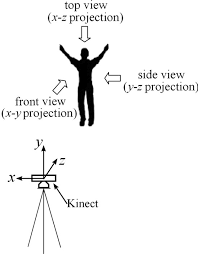

In [2]:
Image('images/sensor.png',width=300)


The available data (.csv files) is called ***raw data***, which has to be preprocessed in order to be better feeded into machine learning models. The raw data is time-series type, and contains essentially three features (x acceleration, y acceleration, z acceleration), in additional to the sequential number and the labels for all the 7 activities. 


## Features in the data

Given the data like this, we can generate samples/features using sliding temporal windows which split the raw data into segments. All the data (x, y, z-accelerations) in each sequence/window form one sample. Starting from the segments/samples, one can proceed in two different ways:



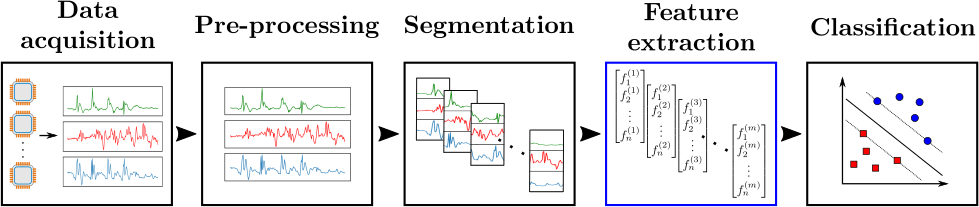

In [3]:
Image('images/process.png')

1. **Generate hand-crafted features:**   For each sample, we extract some new ***time domain features***: 

mean for x, y, z-acceleration:
$$
\widehat \mu_x = \dfrac{1}{N}\sum^N_{i} x_i
$$

variance (standard deviation $\sigma$):
$$
\widehat \sigma^2_x = E(x-\widehat\mu_x)^2  =\dfrac{1}{N} \sum^N_{i} (x_i-\widehat \mu_x)^2
$$

min-max value, mean absolute deviation, skewness (asymmetry): 
$$
Skewness(x) = \dfrac{\sum_i(x_i -\widehat\mu_x)^3}{(\widehat\sigma^2_x)^{3/2}} 
$$

Kurtosis (tailed): 
$$
kurtosis(x) = \dfrac{\sum_i(x_i -\widehat\mu_x)^4}{\widehat\sigma^2_x\widehat\sigma^2_x}
$$

Correlation:
$$
Corr(x,y) = \dfrac{\sum_{i}(x_i -\widehat\mu_x)(y_i -\widehat\mu_y)}{\widehat\sigma_x\widehat\sigma_y}
$$

and magnitude:

$$
magnitude(x,y,z) = \sqrt{\widehat \mu^2_x + \widehat \mu^2_y + \widehat \mu^2_z}.
$$

Besides, we can also extract **Frequency domain features** (computed with Fast Fourier Transform (FFT) over the window),

Energy weighted moments with the order $k=1,2,3$:

$$
 M^{(k)} = \int d\omega \cdot \omega^k \cdot F(\omega),
$$
where 
$$
F(\omega) = \int dt \cdot f(t) e^{-i(2\pi\omega) t}
$$
 
2. We can also simply treat each segment as an "image" and  adopt convolutional neural networks (CNN) to learn all the features in each sample. The dimension of each image/sample is (3, window_size).

 

**Window Size**

Window Size: short window length -> real-time inference of the user's current activity -> detection can rapidly adapt to changes.

 




## Properties of the data

- **The data for each class is imbalance**:  we can introduce different window length/size for the sliding window for different class in such a way that the sample size for each class is similar. 

- **The data of each class is not regular/periodic (lots of frequncies, noise?)**: 


This is a challenge project as there are only three features as functions of time. Moreover,  this is an imbalanced data. The time duration for the longest activity (i.e. Working at Computer) is more than one order of magnitude longer than that for the shorted activity (i.e., Walking and Talking with Someone).



## Metrics

Considering the data is unbalanced and this is a multi-label classification, I will monitor not only the accuracy, but also the precision/recall and F1 score of all classes. In particular, I will print out both
the "macro" and "weighted" f1 scores. 

- The macro F1 score will be calculated using the "macro precision" and "macro recall", which are defined as the 
average precision and recall over all the classes (with equal weight). 

- The weighted F1 score will be calculated by computing the metrics for each label, and finding their average, weighted by the number of true instances for each label. This alters "macro" f1 score to account for label imbalance. It can result in an F-score that is not between precision and recall.


- Confusion Matrix

- Accuracy, precision, recall, f1 score (macro/weighted)


## Model choices

- Machine Learning (Hand Crafted Features/controlable overfitting/ interpretable)
- Deep Learning (Automatic Feature Capture/end-to-end/images)

# Exploratory data analysis

## Load raw data

In [4]:
raw_features = ['Sequential_number', 'x_acceleration', 'y_acceleration', 'z_acceleration', 'label']
dfs      = load_data(raw_features)

Time Duration for the participant 1 is 3125.0 seconds
Time Duration for the participant 2 is 2654.0 seconds
Time Duration for the participant 3 is 1969.0 seconds
Time Duration for the participant 4 is 2350.0 seconds
Time Duration for the participant 5 is 3077.0 seconds
Time Duration for the participant 6 is 2710.0 seconds
Time Duration for the participant 7 is 3135.0 seconds
Time Duration for the participant 8 is 2654.0 seconds
Time Duration for the participant 9 is 3207.0 seconds
Time Duration for the participant 10 is 2439.0 seconds
Time Duration for the participant 11 is 2009.0 seconds
Time Duration for the participant 12 is 2206.0 seconds
Time Duration for the participant 13 is 1301.0 seconds
Time Duration for the participant 14 is 2233.0 seconds
Time Duration for the participant 15 is 1991.0 seconds


Here we plot all the data for the first participant in one figure to get some idea on it globally.

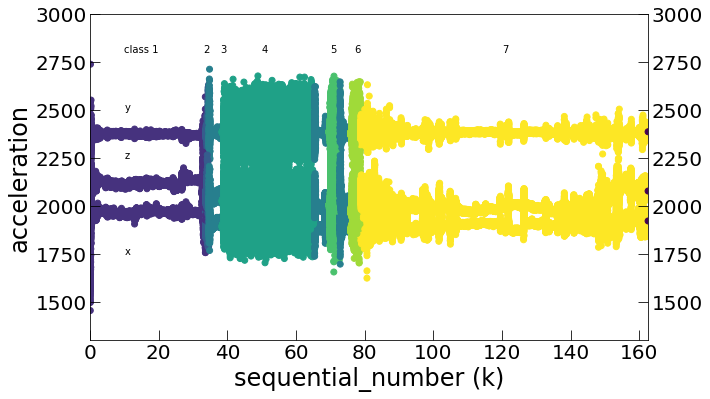

In [3]:
Image('images/paricipant01.png')

Here we divide the entire data into seven parts based on the class/activity label.

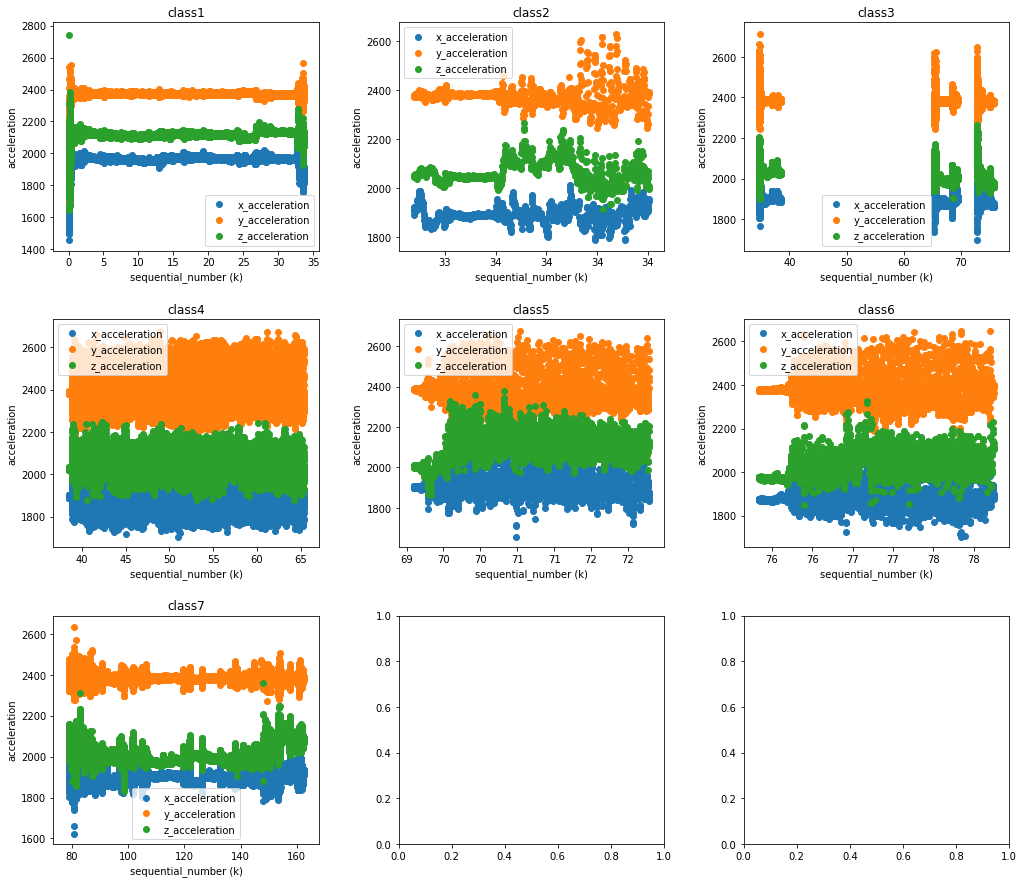

In [5]:
Image('images/paricipant01_class.png')

One can easily see the following properties of the data:
- Imbalance
- Not periodic

In [30]:
# Descriptive Statistics
dfs[0].describe()

Sequential_number x_acceleration y_acceleration z_acceleration  \
count     162500.000000  162500.000000  162500.000000  162500.000000   
mean       81250.500000    1910.673372    2380.287385    2041.214142   
std        46909.853797      40.640690      41.923851      59.528943   
min            1.000000    1455.000000    1697.000000    1644.000000   
25%        40625.750000    1886.000000    2374.000000    1991.000000   
50%        81250.500000    1905.000000    2381.000000    2022.000000   
75%       121880.000000    1935.000000    2386.000000    2101.000000   
max       162500.000000    2356.000000    2713.000000    2739.000000   

               label  
count  162500.000000  
mean        4.899705  
std         2.424299  
min         0.000000  
25%         3.000000  
50%         7.000000  
75%         7.000000  
max         7.000000

**Check if any data is missing**

In [32]:
count_missing = 0
for i in range(8):
    count_missing += dfs[i].isnull().sum().values 
print('Total number of missing data:', count_missing)

Total number of missing data: [0 0 0 0 0]


## Check the data

Generate new features from the **raw** data using sliding temporal windows.

In [16]:
# set parameters for the window size (constant for all classes)
window_size = 260   # 5 seconds
step_size   = 260   # 5 seonds
segments    = []
label       = []

### Check the data for the class 1

Text(400,2600,'Signal')

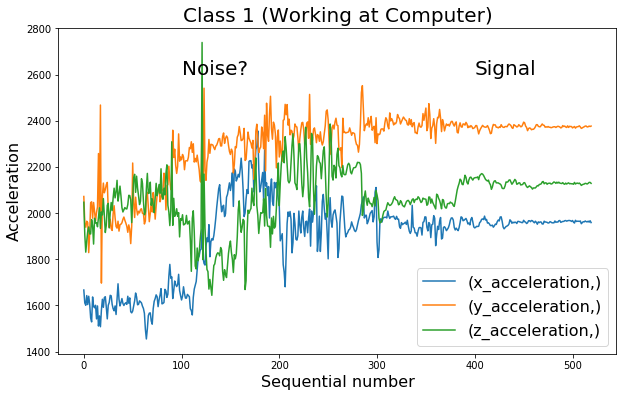

In [9]:
features=['x_acceleration','y_acceleration','z_acceleration']

dfs[0].iloc[:window_size*2][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 1 (Working at Computer)', fontsize=20)
plt.legend(fontsize=16)

plt.text(100,2600,'Noise?',fontsize=20)
plt.text(400,2600,'Signal',fontsize=20)


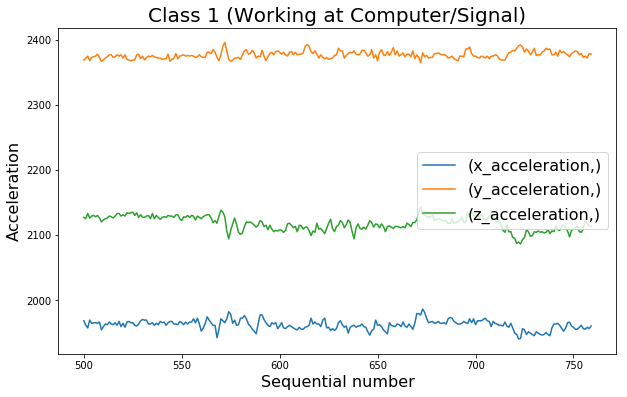

In [13]:
dfs[0].iloc[500:500+window_size][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 1 (Working at Computer/Signal)', fontsize=20)
plt.legend(fontsize=16)

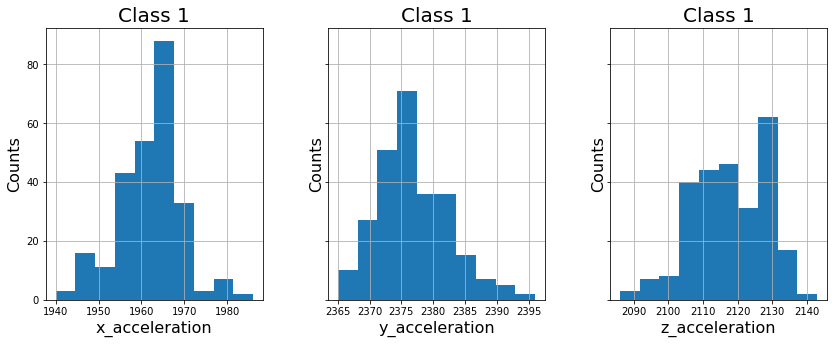

In [12]:
fig, axs = plt.subplots(1, 3,  sharey=True,figsize=(14,5)) 

for feature,j in zip(features, axs): 
    pd.DataFrame(dfs[0][feature].values[500:500+window_size].squeeze()).hist(ax=j)
    j.set_xlabel(feature,fontsize=16) 
    j.set_ylabel('Counts',fontsize=16) 
    j.set_title('Class 1',fontsize=20)

The class 1 is labeled for the activity "Working at Computer". However, one can see that there are two different patterns in the data. <font color='blue'> It might be reasonable to treat the data in the begining (about 5 seconds) and end of the time-series data  as noisesfor the class 1. </font> It might be fair to delete these parts of data to improve the prediction.

### Check the data for the class 2

The data for the class 2 is short! Therefore, we plot the entire data for the class 2.

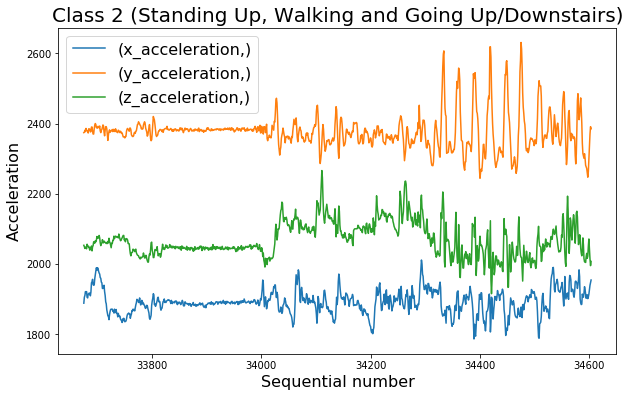

In [115]:
dfs[0][dfs[0]['label'].values==2][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 2 (Standing Up, Walking and Going Up/Downstairs)', fontsize=20)
plt.legend(fontsize=16)

- The class 2 is labeled as "Standing Up, Walking and Going Up/Downstairs", which are acutally three sequential activities. These patterns can be seen clearly from the above figure.

### Check the data for the class 3


<font color='red'> The data for the class 3 needs to be careful, as seen below. </font>

In [141]:
import collections
 
collections.Counter(dfs[0][dfs[0]['label'].values==3]['label'].values.squeeze() )

Counter({3: 11179})

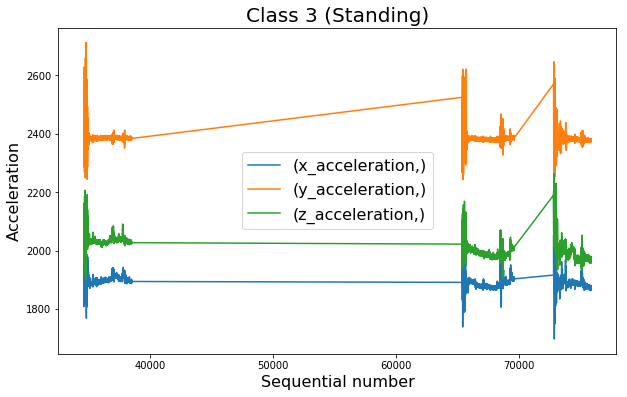

In [157]:
dfs[0][dfs[0]['label'].values==3][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 3 (Standing)', fontsize=20)
plt.legend(fontsize=16)

The above figure displays the entire data ! Two different patterns:

- Standing without move
- Standing with move <font color='red'> (Mislabeling of the data?)</font>

Do we need to take both cases into considerations?

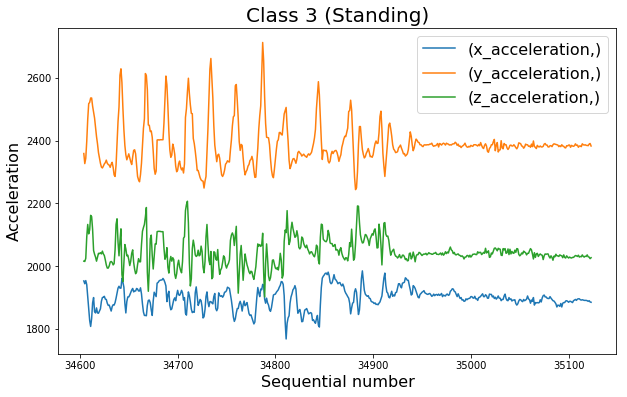

In [144]:
dfs[0][dfs[0]['label'].values==3][:window_size*2][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 3 (Standing)', fontsize=20)
plt.legend(fontsize=16)

 It is seen clearly in the above (zoom in) figure that there are two different activities in this class (standing).

### Check the data for the class 4 

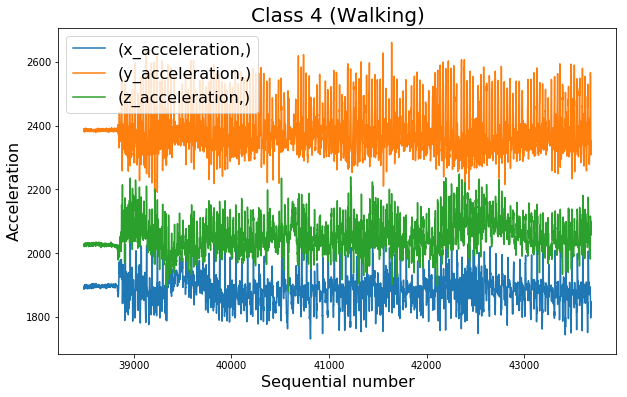

In [170]:
dfs[0][dfs[0]['label'].values==4][:window_size*20][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 4 (Walking)', fontsize=20)
plt.legend(fontsize=16)

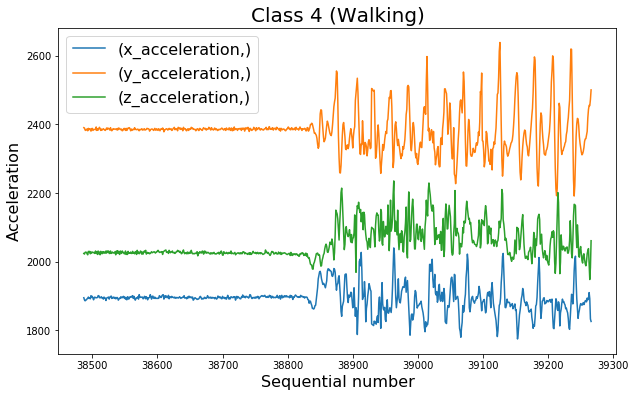

In [147]:
dfs[0][dfs[0]['label'].values==4][:window_size*3][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 4 (Walking)', fontsize=20)
plt.legend(fontsize=16)

- The first part data share very similar pattern to that of the class 3 (standing).   <font color='red'> (Mislabeling of the data?)</font>

- The rest of the data are very clean for classifying the activity "Walking".

### Check the data for the class 5 

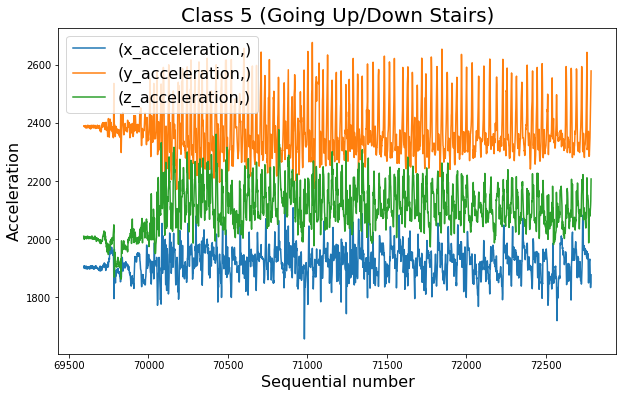

In [172]:
dfs[0][dfs[0]['label'].values==5][:window_size*20][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 5 (Going Up/Down Stairs)', fontsize=20)
plt.legend(fontsize=16)

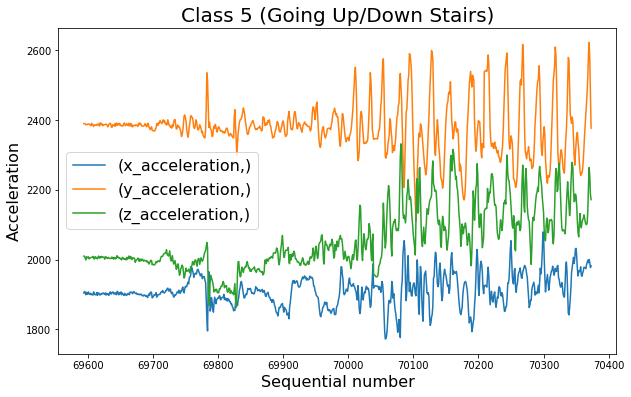

In [175]:
dfs[0][dfs[0]['label'].values==5][:window_size*3][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 5 (Going Up/Down Stairs)', fontsize=20)
plt.legend(fontsize=16)

### Check the data for the class 6

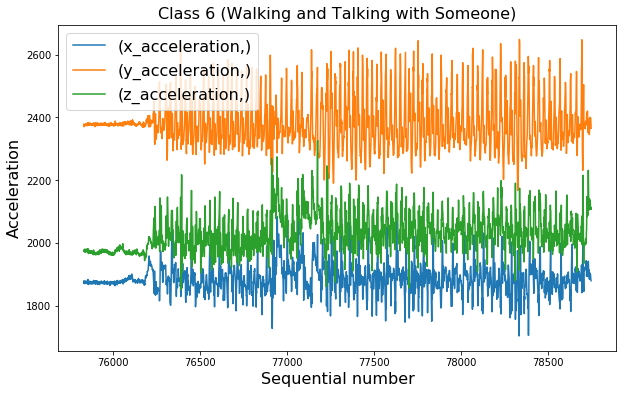

In [177]:
dfs[0][dfs[0]['label'].values==6][:window_size*20][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 6 (Walking and Talking with Someone)', fontsize=16)
plt.legend(fontsize=16)

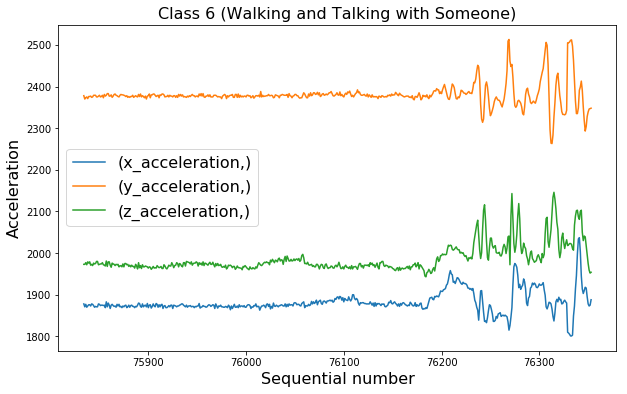

In [178]:
dfs[0][dfs[0]['label'].values==6][:window_size*2][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 6 (Walking and Talking with Someone)', fontsize=16)
plt.legend(fontsize=16)

- The first part data share very similar pattern to that of the class 3 (standing).   <font color='red'> (Mislabeling of the data?)</font>

- The rest of the data are very clean for classifying the activity "Walking".

- Large overlap with the class 4.

### Check the data for the class 7

7: Talking while Standing

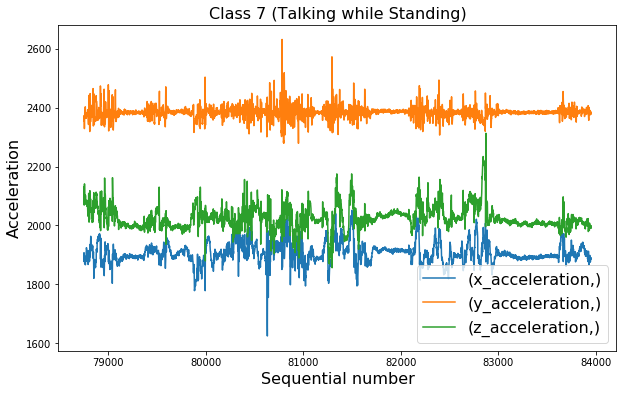

In [181]:
dfs[0][dfs[0]['label'].values==7][:window_size*20][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 7 (Talking while Standing)', fontsize=16)
plt.legend(fontsize=16)

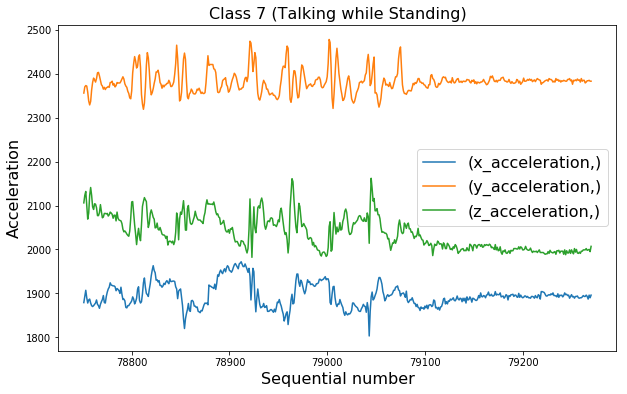

In [182]:
dfs[0][dfs[0]['label'].values==7][:window_size*2][features].plot(figsize=(10,6))
plt.ylabel('Acceleration', fontsize=16)
plt.xlabel('Sequential number', fontsize=16)
plt.title('Class 7 (Talking while Standing)', fontsize=16)
plt.legend(fontsize=16)

- The two activities: talking (with some fluctuation) and standing (more flat), are happening with in a good pattern. 

- Distinguished from others.

**Conclusion:** 

- The data for the class 1 and class 7 are the most distinguishable from others.
- Some mislabelling are shown in the class 3,4, and 6.
- Mixure of activities in the class 2 with the class 3,4,5,6. 

<font color='red'> All these situations make the classification challenge ! </font>

## Fast Fourier Transformation (FFT)

### A simple test of the implementation of the FFT

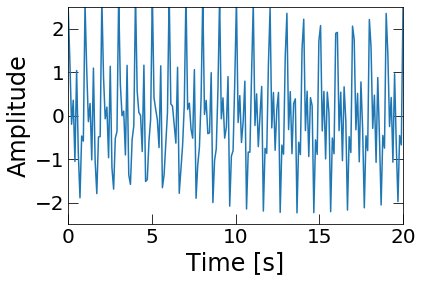

In [13]:
time_interval = 0.1   # seconds
sample_size  =  200   # 20 seconds
freq_test = [1,2,4]  # signal is a superposition of three frequencies

t = np.linspace(0,sample_size*time_interval,sample_size)  # 10 seconds, 100 points

# generate a superposition of three signals
st = 0
for freq in freq_test:
    st += np.sin(2*np.pi*freq*t+np.random.rand()*np.pi/2) # add a random phase
    
# visualization of the signal    
plt.plot(t,st)

set_figstyle(0,20,-2.5,2.5,'Time [s]','Amplitude',False) 

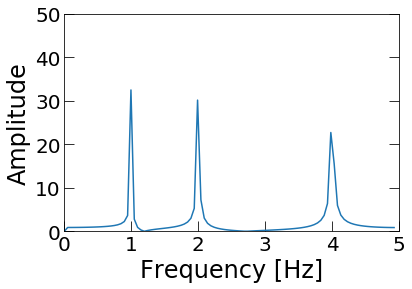

In [14]:
fcs = Fast_Fourier_Transformation(time_interval,st) 
set_figstyle(0,5,0,50,'Frequency [Hz]','Amplitude',False) 

### Process the raw data

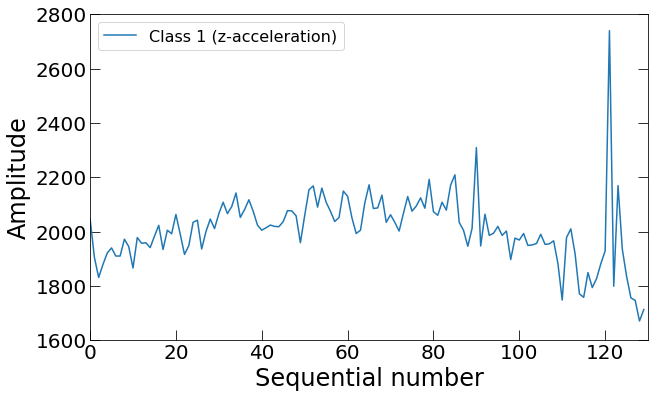

In [27]:
 # set parameters for the window size  
window_size = 260   # 5 seconds 
length = window_size/2

# 
st = dfs[0][dfs[0]['label'].values==1][:int(length)]['z_acceleration']
st.plot(figsize=(10,6))
plt.legend(['Class 1 (z-acceleration)'], fontsize=16)
set_figstyle(0,length,1600,2800,'Sequential number','Amplitude',False)

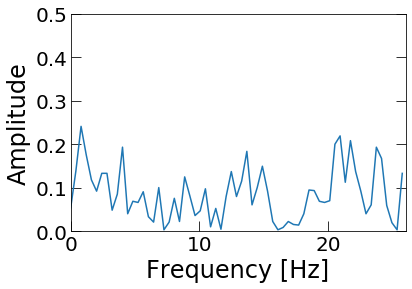

In [33]:
time_interval = 1/52.0
fcs = Fast_Fourier_Transformation(time_interval,st)
set_figstyle(0,int(1/(time_interval*2)),0,0.5,'Frequency [Hz]','Amplitude',False) 

## Generate handed-crafted features and save  the derived samples


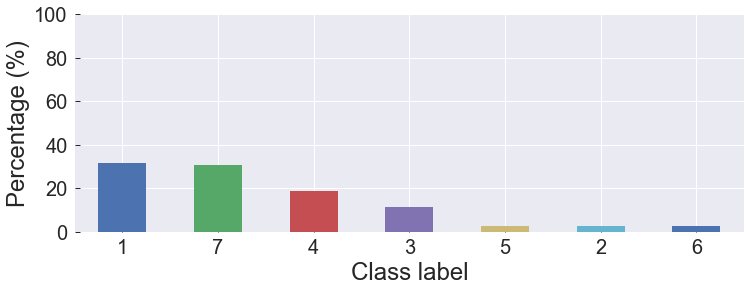

In [183]:
Image('images/percentage_origin.png')

The imbalance property of the data is shown in the original data. 

**In order to get a balanced training and test datasets, here we use the ratio to the shortest class to define different window size for different class.**

In [34]:
# if the ratio is known already, one can start from here directly
ratios = np.array([12, 1, 4, 7, 1, 1, 12])

# set hyperparameters for the window
# times of 0.5 seconds
window_size_array    =  np.multiply(ratios, 26)              

# half window_size 50% overlaping between samples, more data samples
step_size_array_ovlp         =  np.multiply(window_size_array,0.5).astype(int)  
# half window_size 50% overlaping between samples, more data samples
step_size_array_no_ovlp      =  np.multiply(window_size_array,1).astype(int) 

time_interval = 1.0/52 # 52Hz 

segments_balanced    = []
label_balanced       = []

** Generate Two Types of Data**

- with 50% overlap
- without overlap

In [35]:

segments_array_balanced_ovlp = np.array(get_features_balanced(dfs, 
                                                         window_size_array, 
                                                         step_size_array_ovlp,  
                                                              time_interval))

class: 1, window_size: 312, step_size: 156, sample_size: 3900
class: 2, window_size: 26, step_size: 13, sample_size: 3681
class: 3, window_size: 104, step_size: 52, sample_size: 4167
class: 4, window_size: 182, step_size: 91, sample_size: 3922
class: 5, window_size: 26, step_size: 13, sample_size: 3960
class: 6, window_size: 26, step_size: 13, sample_size: 3673
class: 7, window_size: 312, step_size: 156, sample_size: 3803


In [40]:
segments_balanced_ovlp_df = pd.DataFrame(segments_array_balanced_ovlp)

segments_balanced_ovlp_df.columns =['x_mean', 'y_mean', 'z_mean', 
                     'x_var', 'y_var', 'z_var', 
                     'x_max', 'y_max', 'z_max', 
                     'x_min', 'y_min', 'z_min', 
                     'x_mad', 'y_mad', 'z_mad', 
                     'x_sum', 'y_sum', 'z_sum',
                     'magnitude',
                    'corr_xy','corr_yz','corr_zx',
                     'skew_x','skew_y','skew_z',
                     'kurt_x','kurt_y','kurt_z', 
                    'x_moment1','x_moment2','x_moment3',
                    'y_moment1','y_moment2','y_moment3',
                    'z_moment1','z_moment2','z_moment3',
                     'label']

# caution: x_sum, y_sum, z_sum are directly connected with the class label (added based on sample size
# of each class), therefore, these three should NOT be included in the features.
# Definitely, including them will increase the precision score by about 0.1

#segments_balanced_ovlp_df.drop(['x_sum', 'y_sum', 'z_sum'], axis=1, inplace=True)

segments_balanced_ovlp_df['label'] = segments_balanced_ovlp_df['label'].map(int)

 

# Save generated data into file

#segments_balanced_ovlp_df.to_csv('HAR_Processed_Data_X34Y1.csv') 

In [47]:

segments_array_balanced_no_ovlp = np.array(get_features_balanced(dfs, 
                                                         window_size_array, 
                                                         step_size_array_no_ovlp,  
                                                        time_interval))

class: 1, window_size: 312, step_size: 312, sample_size: 1950
class: 2, window_size: 26, step_size: 26, sample_size: 1841
class: 3, window_size: 104, step_size: 104, sample_size: 2084
class: 4, window_size: 182, step_size: 182, sample_size: 1961
class: 5, window_size: 26, step_size: 26, sample_size: 1980
class: 6, window_size: 26, step_size: 26, sample_size: 1837
class: 7, window_size: 312, step_size: 312, sample_size: 1902


In [48]:
segments_balanced_no_ovlp_df = pd.DataFrame(segments_array_balanced_no_ovlp)

segments_balanced_no_ovlp_df.columns =['x_mean', 'y_mean', 'z_mean', 
                     'x_var', 'y_var', 'z_var', 
                     'x_max', 'y_max', 'z_max', 
                     'x_min', 'y_min', 'z_min', 
                     'x_mad', 'y_mad', 'z_mad', 
                     'x_sum', 'y_sum', 'z_sum',
                     'magnitude',
                    'corr_xy','corr_yz','corr_zx',
                     'skew_x','skew_y','skew_z',
                     'kurt_x','kurt_y','kurt_z', 
                    'x_moment1','x_moment2','x_moment3',
                    'y_moment1','y_moment2','y_moment3',
                    'z_moment1','z_moment2','z_moment3',
                     'label']

# caution: x_sum, y_sum, z_sum are directly connected with the class label (added based on sample size
# of each class), therefore, these three should NOT be included in the features.
# Definitely, including them will increase the precision score by about 0.1

segments_balanced_no_ovlp_df.drop(['x_sum', 'y_sum', 'z_sum'], axis=1, inplace=True)

segments_balanced_no_ovlp_df['label'] = segments_balanced_no_ovlp_df['label'].map(int)



# Save generated data into file

segments_balanced_no_ovlp_df.to_csv('HAR_Processed_Data_X34Y1_no_ovlp.csv')



## Read saved sample data

In [2]:
segments_balanced_ovlp_df = pd.read_csv("HAR_Processed_Data_X34Y1_half_ovlp.csv")
segments_balanced_ovlp_df.drop(['Unnamed: 0'], axis=1, inplace=True)
segments_balanced_ovlp_df.head()

x_mean       y_mean       z_mean         x_var         y_var  \
0  1857.576923  2234.730769  2038.778846  43962.660750  25405.151874   
1  1981.000000  2364.179487  2101.051282   7383.294872   2538.544707   
2  1958.730769  2378.487179  2108.839744    301.472387    263.461374   
3  1961.342949  2377.006410  2117.926282     51.853540     28.243549   
4  1954.923077  2379.605769  2106.346154    154.378698     79.136249   

          z_var   x_max   y_max   z_max   x_min  ...     x_moment1  \
0  23328.390194  2356.0  2552.0  2739.0  1455.0  ...    774.384386   
1   9330.381986  2356.0  2552.0  2386.0  1681.0  ...    319.261050   
2   1241.474318  2034.0  2474.0  2171.0  1859.0  ...    343.192635   
3    132.677258  1986.0  2396.0  2143.0  1940.0  ...    418.441597   
4    322.412229  1999.0  2409.0  2168.0  1919.0  ...    303.950932   

      x_moment2      x_moment3   y_moment1    y_moment2      y_moment3  \
0  12638.274495  240969.888825  673.338441  9243.553121  156938.179066   
1   4649.033218   82896.534274  460.180581  7424.170584  138177.315487   
2   4681.431590   76247.606892  231.367917  3341.262601   59394.699487   
3   7478.729301  145918.606873  461.273581  8121.110478  159390.383521   
4   4540.559604   77774.970686  280.869802  4530.741391   82436.803382   

    z_moment1     z_moment2      z_moment3  label  
0  449.285483   9212.245124  198843.646894      1  
1  682.843073  11153.084203  208792.044329      1  
2  973.630217  13504.593886  221902.860582      1  
3  726.493873  12071.283706  230533.719782      1  
4  305.750191   4638.476148   81681.772382      1  

[5 rows x 35 columns]

In [3]:
segments_balanced_ovlp_df.describe()

x_mean        y_mean        z_mean          x_var          y_var  \
count  27106.000000  27106.000000  27106.000000   27106.000000   27106.000000   
mean    1992.163004   2380.101758   1968.023928    1228.942788    2867.157133   
std      110.056912     82.481136     84.497296    3428.052888    6740.466809   
min     1669.320513   1855.240385   1635.637821       2.995562       2.331361   
25%     1901.156593   2340.516484   1916.980769      13.079494      10.791166   
50%     2008.405449   2364.506410   1984.225962     121.517438      82.214497   
75%     2085.306891   2390.884615   2029.884615    1637.118638    4406.206361   
max     2318.778846   2592.269231   2224.230769  182192.448841  339738.042858   

               z_var         x_max         y_max         z_max         x_min  \
count   27106.000000  27106.000000  27106.000000  27106.000000  27106.000000   
mean     1472.195794   2051.096953   2464.022172   2031.446396   1936.208994   
std      5280.623622    131.735597    136.946612    126.152769    132.728755   
min         2.467456   1718.000000   1881.000000   1644.000000    282.000000   
25%        14.222068   1958.000000   2365.000000   1965.000000   1856.000000   
50%       122.455436   2057.000000   2425.000000   2031.000000   1946.000000   
75%      2002.473259   2133.000000   2550.000000   2104.000000   2037.000000   
max    346157.945883   3828.000000   4095.000000   4095.000000   2237.000000   

           ...          x_moment1     x_moment2      x_moment3     y_moment1  \
count      ...       27106.000000  27106.000000   27106.000000  27106.000000   
mean       ...         264.608482   4541.576865   88115.583209    246.102951   
std        ...         232.103977   4017.187886   78754.924584    200.339920   
min        ...           1.975588     32.900788     607.376832      4.756157   
25%        ...          71.067186   1213.714699   23411.285953     69.806531   
50%        ...         200.298356   3391.116232   64639.608409    192.417364   
75%        ...         418.035250   7140.311029  138923.564796    396.424975   
max        ...        2326.947430  39041.821784  739151.811538   1826.637249   

          y_moment2      y_moment3     z_moment1     z_moment2      z_moment3  \
count  27106.000000   27106.000000  27106.000000  27106.000000   27106.000000   
mean    4247.567098   82635.194994    263.752566   4521.079648   87661.441906   
std     3493.062141   68621.473484    229.628199   3973.083742   77871.548937   
min       86.998113    1667.246493      3.238197     55.749421     790.841629   
25%     1203.569701   23214.933317     71.361127   1212.684424   23291.261881   
50%     3274.273546   62695.953809    200.660437   3411.339615   65348.099878   
75%     6831.695413  132392.999844    406.731893   6973.505800  135063.882715   
max    31695.352748  618326.138185   1995.511590  37897.558496  742543.486992   

              label  
count  27106.000000  
mean       3.981037  
std        1.985562  
min        1.000000  
25%        2.000000  
50%        4.000000  
75%        6.000000  
max        7.000000  

[8 rows x 35 columns]

In [4]:
segments_balanced_ovlp_df_no_moments = segments_balanced_ovlp_df.copy() 
segments_balanced_ovlp_df_no_moments.drop([
                    'x_moment1','x_moment2','x_moment3',
                    'y_moment1','y_moment2','y_moment3',
                    'z_moment1','z_moment2','z_moment3'],axis=1,inplace=True)

In [5]:
segments_balanced_no_ovlp_df = pd.read_csv("HAR_Processed_Data_X34Y1_no_ovlp.csv")

segments_balanced_no_ovlp_df.drop(['Unnamed: 0'], axis=1, inplace=True)
segments_balanced_no_ovlp_df.head()

x_mean       y_mean       z_mean         x_var         y_var  \
0  1857.576923  2234.730769  2038.778846  43962.660750  25405.151874   
1  1958.730769  2378.487179  2108.839744    301.472387    263.461374   
2  1954.923077  2379.605769  2106.346154    154.378698     79.136249   
3  1962.445513  2379.278846  2110.224359     55.304723     20.335706   
4  1961.551282  2378.365385  2112.121795     28.689678      8.783161   

          z_var   x_max   y_max   z_max   x_min  ...     x_moment1  \
0  23328.390194  2356.0  2552.0  2739.0  1455.0  ...    774.384386   
1   1241.474318  2034.0  2474.0  2171.0  1859.0  ...    343.192635   
2    322.412229  1999.0  2409.0  2168.0  1919.0  ...    303.950932   
3     81.020176  1980.0  2394.0  2138.0  1938.0  ...    651.351068   
4     25.183884  1978.0  2388.0  2127.0  1948.0  ...    392.460015   

      x_moment2      x_moment3   y_moment1     y_moment2      y_moment3  \
0  12638.274495  240969.888825  673.338441   9243.553121  156938.179066   
1   4681.431590   76247.606892  231.367917   3341.262601   59394.699487   
2   4540.559604   77774.970686  280.869802   4530.741391   82436.803382   
3  10587.208379  199097.854133  533.050319   8848.030435  166566.986542   
4   6990.188159  137540.046860  553.174859  10031.174624  199987.391620   

    z_moment1     z_moment2      z_moment3  label  
0  449.285483   9212.245124  198843.646894      1  
1  973.630217  13504.593886  221902.860582      1  
2  305.750191   4638.476148   81681.772382      1  
3  484.504125   7309.515257  130001.885435      1  
4  537.564266  10238.502190  209805.853713      1  

[5 rows x 35 columns]

In [6]:
segments_balanced_no_ovlp_df_no_moments = segments_balanced_no_ovlp_df.copy()
segments_balanced_no_ovlp_df_no_moments.columns

segments_balanced_no_ovlp_df_no_moments.drop([
                    'x_moment1','x_moment2','x_moment3',
                    'y_moment1','y_moment2','y_moment3',
                    'z_moment1','z_moment2','z_moment3'],axis=1,inplace=True)

- **The sample size of "segments_balanced_no_ovlp_df" is half of that of *segments_balanced_ovlp_df**.

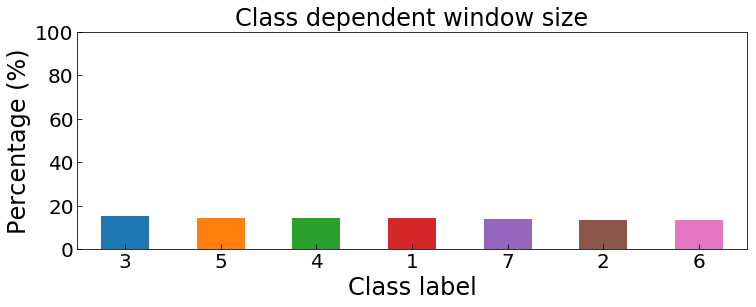

In [7]:

(segments_balanced_no_ovlp_df.label.value_counts(sort=True)/segments_balanced_no_ovlp_df.shape[0]*100).plot(kind='bar',fontsize=24,figsize=(12,4));
plt.xticks(rotation=0)
plt.ylim(0,100) 
plt.xlabel('Class label',fontsize=24)
plt.ylabel('Percentage (%)',fontsize=24)
plt.tick_params(which='major',direction='in',length=5,labelsize=20) 
plt.tight_layout
plt.title('Class dependent window size', fontsize=24)
plt.savefig('HAR/figs/percentage_balanced.png')

- The above figure shows that the new dataset of the generated samples is balanced.  

## Scale and split the data

### Dataset with 34 hand-crafted features

**Split the Data with half overlaping**

In [8]:
X34_ovlp = segments_balanced_ovlp_df.iloc[:,:-1].values
y34_ovlp = segments_balanced_ovlp_df['label'].iloc[:].values

In [9]:
scaler_pipeline = Pipeline([
                    ('robust_scaler',RobustScaler())  
                    ])
segments_scaled = [] 
segments_scaled.append(scaler_pipeline.fit_transform(X34_ovlp))

X34_scaled_ovlp = np.array(segments_scaled).squeeze() 

In [10]:
# random state is choosen as 10% of each sample size

random_state = int(segments_balanced_ovlp_df.shape[0]/70)
X34_train_ovlp, X34_test_ovlp,  \
y34_train_ovlp, y34_test_ovlp = train_test_split(X34_scaled_ovlp, y34_ovlp, 
                                                    test_size = 0.2, 
                                                    random_state = random_state )

print ("number of training segments/samples = " + str(X34_train_ovlp.shape[0]))
print ("number of test segments/samples = " + str(X34_test_ovlp.shape[0]))
print ("X_train shape: " + str(X34_train_ovlp.shape))
print ("Y_train shape: " + str(y34_train_ovlp.shape))
print ("X_test shape: " + str(X34_test_ovlp.shape))
print ("Y_test shape: " + str(y34_test_ovlp.shape))


number of training segments/samples = 21684
number of test segments/samples = 5422
X_train shape: (21684, 34)
Y_train shape: (21684,)
X_test shape: (5422, 34)
Y_test shape: (5422,)


**Split the Data with without overlaping**

In [11]:
X34_novlp = segments_balanced_no_ovlp_df.iloc[:,:-1].values
y34_novlp = segments_balanced_no_ovlp_df['label'].iloc[:].values

In [12]:
scaler_pipeline = Pipeline([
                    ('robust_scaler',RobustScaler())  
                    ])
segments_scaled = [] 
segments_scaled.append(scaler_pipeline.fit_transform(X34_novlp))

X34_scaled_novlp = np.array(segments_scaled).squeeze() 

In [13]:
# random state is choosen as 10% of each sample size

random_state = int(segments_balanced_no_ovlp_df.shape[0]/70)
X34_train_novlp, X34_test_novlp,  \
y34_train_novlp, y34_test_novlp = train_test_split(X34_scaled_novlp, y34_novlp, 
                                                    test_size = 0.2, 
                                                    random_state = random_state )

print ("number of training segments/samples = " + str(X34_train_novlp.shape[0]))
print ("number of test segments/samples = " + str(X34_test_novlp.shape[0]))
print ("X_train shape: " + str(X34_train_novlp.shape))
print ("Y_train shape: " + str(y34_train_novlp.shape))
print ("X_test shape: " + str(X34_test_novlp.shape))
print ("Y_test shape: " + str(y34_test_novlp.shape))

number of training segments/samples = 10844
number of test segments/samples = 2711
X_train shape: (10844, 34)
Y_train shape: (10844,)
X_test shape: (2711, 34)
Y_test shape: (2711,)


**Split the Data with 25 features and half/without overlaping**

In [14]:
X25_ovlp = segments_balanced_ovlp_df_no_moments.iloc[:,:-1].values
y25_ovlp = segments_balanced_ovlp_df_no_moments['label'].iloc[:].values
random_state = int(segments_balanced_ovlp_df_no_moments.shape[0]/70)

scaler_pipeline = Pipeline([
                    ('robust_scaler',RobustScaler())  
                    ])
segments_scaled = [] 
segments_scaled.append(scaler_pipeline.fit_transform(X25_ovlp))

X25_scaled_ovlp = np.array(segments_scaled).squeeze() 

# random state is choosen as 10% of each sample size

X25_train_ovlp, X25_test_ovlp,  \
y25_train_ovlp, y25_test_ovlp = train_test_split(X25_scaled_ovlp, y25_ovlp, 
                                                    test_size = 0.2, 
                                                    random_state = random_state )

print ("number of training segments/samples = " + str(X25_train_ovlp.shape[0]))
print ("number of test segments/samples = " + str(X25_test_ovlp.shape[0]))
print ("X_train shape: " + str(X25_train_ovlp.shape))
print ("Y_train shape: " + str(y25_train_ovlp.shape))
print ("X_test shape: " + str(X25_test_ovlp.shape))
print ("Y_test shape: " + str(y25_test_ovlp.shape))

number of training segments/samples = 21684
number of test segments/samples = 5422
X_train shape: (21684, 25)
Y_train shape: (21684,)
X_test shape: (5422, 25)
Y_test shape: (5422,)


In [15]:
X25_novlp = segments_balanced_no_ovlp_df_no_moments.iloc[:,:-1].values
y25_novlp = segments_balanced_no_ovlp_df_no_moments['label'].iloc[:].values
random_state = int(segments_balanced_no_ovlp_df_no_moments.shape[0]/70)

scaler_pipeline = Pipeline([
                    ('robust_scaler',RobustScaler())  
                    ])
segments_scaled = [] 
segments_scaled.append(scaler_pipeline.fit_transform(X25_novlp))

X25_scaled_novlp = np.array(segments_scaled).squeeze() 

# random state is choosen as 10% of each sample size

X25_train_novlp, X25_test_novlp,  \
y25_train_novlp, y25_test_novlp = train_test_split(X25_scaled_novlp, y25_novlp, 
                                                    test_size = 0.2, 
                                                    random_state = random_state )

print ("number of training segments/samples = " + str(X25_train_novlp.shape[0]))
print ("number of test segments/samples = " + str(X25_test_novlp.shape[0]))
print ("X_train shape: " + str(X25_train_novlp.shape))
print ("Y_train shape: " + str(y25_train_novlp.shape))
print ("X_test shape: " + str(X25_test_novlp.shape))
print ("Y_test shape: " + str(y25_test_novlp.shape))

number of training segments/samples = 10844
number of test segments/samples = 2711
X_train shape: (10844, 25)
Y_train shape: (10844,)
X_test shape: (2711, 25)
Y_test shape: (2711,)


**Check if the data are split into balanced training and test data sets**

In [22]:
import collections

counter_train = collections.Counter(y34_train_novlp)
counter_test  = collections.Counter(y34_test_novlp)

counter_train_dic = dict(counter_train)
counter_test_dic  = dict(counter_test)

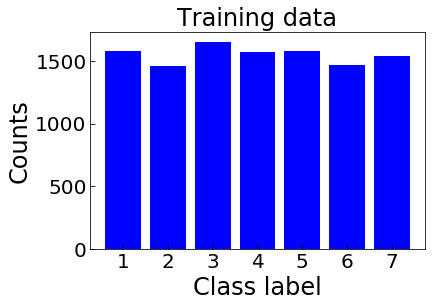

In [17]:
plt.bar(counter_train_dic.keys(), counter_train_dic.values(), color='b')
plt.xlabel('Class label',fontsize=24)
plt.ylabel('Counts',fontsize=24)
plt.tick_params(which='major',direction='in',length=5,labelsize=20) 
plt.xticks([1,2,3,4,5,6,7])
plt.title('Training data', fontsize = 24)
plt.show()

## Visualization the sample data in low dimension using PCA and t-SNE

-  PCA is a linear dimension reduction technique that seeks to maximize variance and preserves large pairwise distances.

- t-SNE preserves only small pairwise distances or local similarities. The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. 

In [19]:
pca = PCA()
pca.fit(X34_train_novlp)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.95)
X_reduced = pca.fit_transform(X34_train_novlp)

print("Dimension needed to capture >95% features of the data: {}".format(d))

Dimension needed to capture >95% features of the data: 12


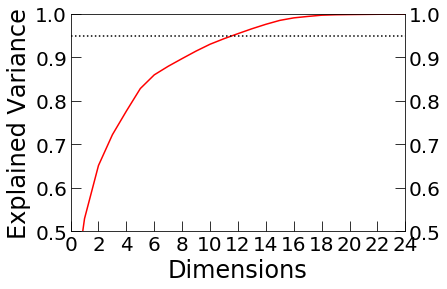

In [20]:
plt.plot(cumsum,c='r')
set_figstyle(0,12,0.5,1,'Dimensions','Explained Variance',True)
plt.xticks(list(range(0,26,2) ))
plt.axhline(0.95,linestyle=':',c='k')

In [21]:
df4pca_X34 = CompressedData_PCA(X34_train_novlp, y34_train_novlp)

Explained variation per principal component: [0.30143234 0.22768993 0.12214662]


In [22]:
X34_train_novlp_reduced = PCA(n_components=2).fit_transform(X34_train_novlp)

pca2_df=pd.DataFrame(X34_train_novlp_reduced)
pca2_df.columns=['1st-comp','2nd-comp']
pca2_df['label']=y34_train_novlp


Text(0.5,1,'PCA decomposition into two components')

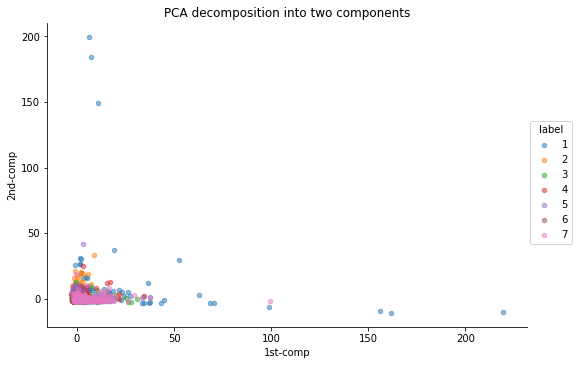

In [80]:
# Use the 'hue' argument to provide a factor variable


sns.lmplot(x='1st-comp', y='2nd-comp', data=pca2_df, 
           fit_reg=False, hue='label', 
           scatter_kws={
               's':20,
               'alpha':0.5
           }, 
           size=5, aspect=1.5,
           legend=True) 

plt.gca().set_title('PCA decomposition into two components')

In [17]:
from sklearn.manifold import TSNE
import os 

In [28]:
isexist = os.path.isfile('tsne_X34_novlp.csv')

if isexist:
    tsne_df = pd.read_csv('tsne_X34_novlp.csv')
    tsne_df = tsne_df.drop(['Unnamed: 0'],axis=1)
else:
    tsne = TSNE(n_components=3, init='random',random_state=0).fit_transform(X34_train_novlp)
    tsne_df=pd.DataFrame(tsne)
    tsne_df.columns=['1st-comp','2nd-comp','3rd-comp']
    tsne_df['label']=y34_train_novlp
    tsne_df.to_csv('tsne_X34_novlp.csv')



In [29]:
tsne_df.head()

1st-comp   2nd-comp   3rd-comp  label
0   4.066263   4.595529  -7.939592      6
1   9.472577  -6.255437  21.087477      7
2   9.454088  14.693398  -7.549755      6
3 -18.221546   3.645743  -3.006377      3
4  -6.067655 -22.112658   1.161417      2

W0408 08:23:56.064356 4747552192 legend.py:1384] No handles with labels found to put in legend.


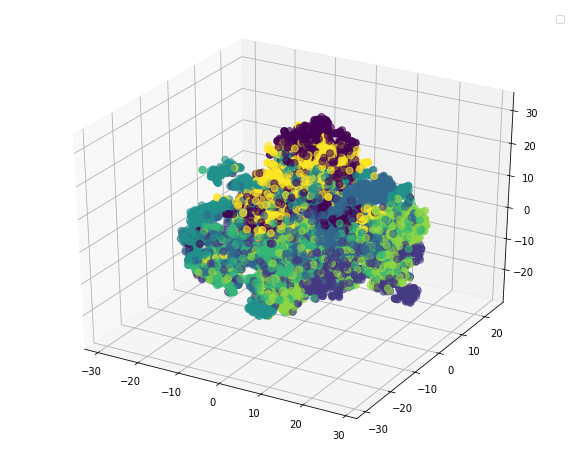

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(*zip(*tsne))
# plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs = tsne_df['1st-comp']
ys = tsne_df['2nd-comp']
zs = tsne_df['3rd-comp']
ax.scatter(xs, ys, zs, s=50, c=tsne_df['label'], alpha=0.6)
ax.legend()

In [40]:
tsne_df.shape

(10844, 4)

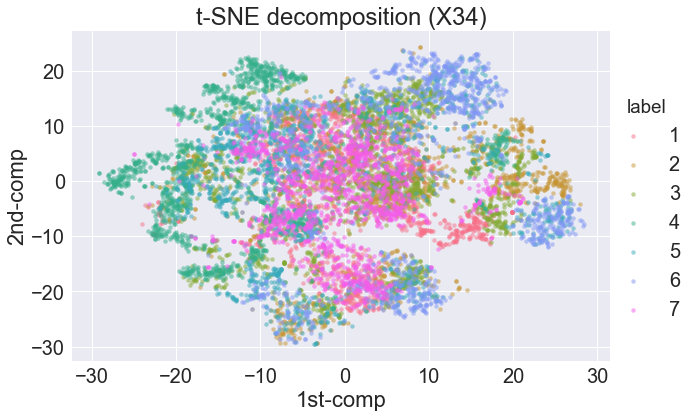

In [49]:
# Use the 'hue' argument to provide a factor variable
sns.set(font_scale=2)
sns.lmplot(x='1st-comp', y='2nd-comp', data=tsne_df, 
           fit_reg=False, hue='label', 
           scatter_kws={
               's':20,
               'alpha':0.5
           }, 
           size=6, aspect=1.5,
           legend=True,
          );

plt.gca().set_title('t-SNE decomposition (X34)')
plt.savefig('HAR/figs/tSNE12.png')

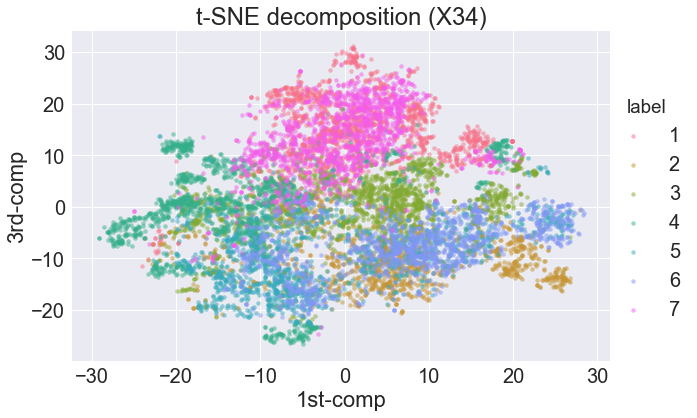

In [50]:
# Use the 'hue' argument to provide a factor variable

sns.lmplot(x='1st-comp', y='3rd-comp', data=tsne_df, 
           fit_reg=False, hue='label', 
           scatter_kws={
               's':20,
               'alpha':0.5
           }, 
           size=6, aspect=1.5,
           legend=True);

plt.gca().set_title('t-SNE decomposition (X34)')
plt.savefig('HAR/figs/tSNE13.png')

In [32]:
X34_train_novlp.shape

(10844, 34)

## t-SNE for the data with 25 features

In [45]:
isexist = os.path.isfile('tsne_X25_novlp.csv')

if isexist:
    tsne_df25 = pd.read_csv('tsne_X25_novlp.csv')
    tsne_df25 = tsne_df25.drop(['Unnamed: 0'],axis=1)
else:
    tsne25 = TSNE(n_components=3, init='random',random_state=0).fit_transform(X25_train_novlp)
    tsne_df25 = pd.DataFrame(tsne25)
    tsne_df25.columns = ['1st-comp','2nd-comp','3rd-comp']
    tsne_df25['label']= y25_train_novlp
    tsne_df25.to_csv('tsne_X25_novlp.csv')



In [46]:

tsne_df25.head()

1st-comp   2nd-comp   3rd-comp  label
0   0.823611   9.237018   1.613619      6
1  12.063102  -1.056864  12.046203      7
2  -6.406441  -4.274831  24.955502      6
3  -9.372096  -2.721647 -11.986470      3
4  -3.315029 -23.504873  -9.362423      2

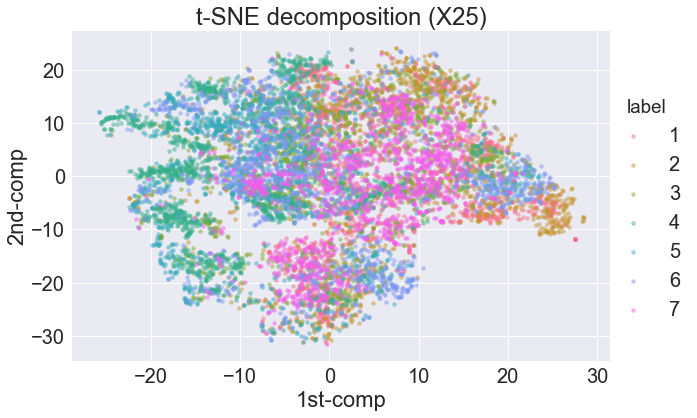

In [47]:
# Use the 'hue' argument to provide a factor variable
sns.set(font_scale=2)
sns.lmplot(x='1st-comp', y='2nd-comp', data=tsne_df25, 
           fit_reg=False, hue='label', 
           scatter_kws={
               's':20,
               'alpha':0.5
           }, 
           size=6, aspect=1.5,
           legend=True,
          );

plt.gca().set_title('t-SNE decomposition (X25)')
plt.savefig('HAR/figs/tSNE12_X25.png')

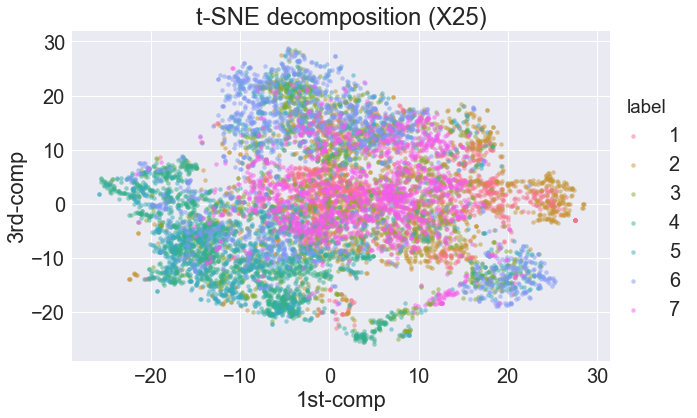

In [48]:
# Use the 'hue' argument to provide a factor variable

sns.lmplot(x='1st-comp', y='3rd-comp', data=tsne_df25, 
           fit_reg=False, hue='label', 
           scatter_kws={
               's':20,
               'alpha':0.5
           }, 
           size=6, aspect=1.5,
           legend=True);

plt.gca().set_title('t-SNE decomposition (X25)')
plt.savefig('HAR/figs/tSNE13_X25.png')

# Model Choices

## Random Forest 



- provide importance of features
- prone to overfit data



Hyperparameters:

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)


Difference between "min_samples_split" and "min_samples_leaf":

For the parameters: 
min_samples_split = 5,
min_samples_leaf  = 2,

Suppose 7 samples at an internal node, then it is allowed by "min_samples_split=5" to split further,
but one cannot split results in two leaves, one with 1 sample (<2), and another with 6 samples.

### Using X34 data with no overlaping between windows

In [18]:
# use the data with 34 features and no overlap between windows
X_train = X34_train_novlp
y_train = y34_train_novlp
X_test  = X34_test_novlp
y_test  = y34_test_novlp

df4samples = segments_balanced_no_ovlp_df

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier().fit(X=X_train, y=y_train)

y_pred   = rf_clf.predict(X_test)        
rf_clf_cm = metrics.confusion_matrix(y_test,y_pred)

print(rf_clf_cm)

[[334   1   4   3   0   0  28]
 [  0 322   3   0  36  22   0]
 [  6   1 411   9   2   2   5]
 [  3   1   9 372   0   0   7]
 [  0  26   2   0 339  33   0]
 [  0  29   0   0  61 278   0]
 [ 23   0  10   8   0   0 321]]


In [53]:
feature_importances = pd.DataFrame(rf_clf.feature_importances_, 
                                   index = df4samples.columns.values[:-1], 
                                   columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [54]:
feature_importances.reset_index(inplace=True)

Text(0.5,0,'Importance')

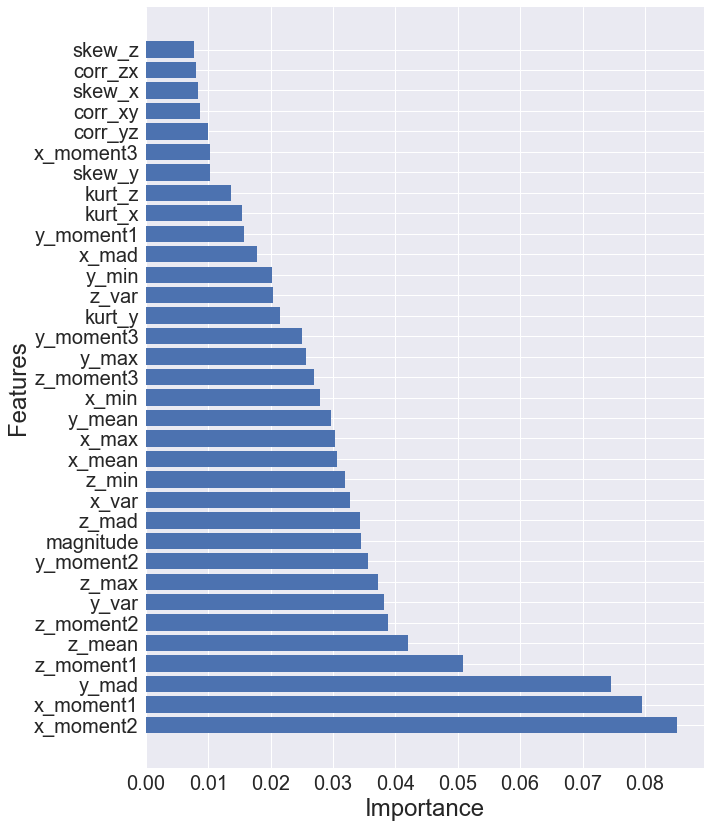

In [58]:

plt.figure(figsize=(10,14))
plt.barh(feature_importances['index'],feature_importances['importance'])  
plt.ylabel('Features',fontsize=24)
plt.xlabel('Importance',fontsize=24)

In [60]:
print(rf_clf_cm)

[[333   0   2   3   0   0  32]
 [  0 332   2   0  27  22   0]
 [  4   2 414   8   1   4   3]
 [  3   1  10 372   0   1   5]
 [  0  25   3   0 338  34   0]
 [  0  29   0   0  65 274   0]
 [ 22   0   9   5   0   2 324]]


([<matplotlib.axis.YTick at 0x13ee4f860>,
 <a list of 7 Text yticklabel objects>)

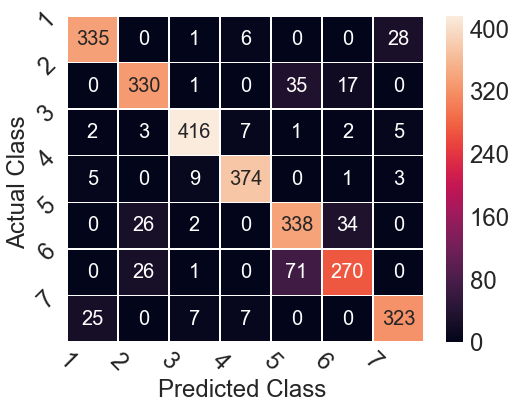

In [20]:
rf_clf = make_pipeline(RobustScaler(),
                    RandomForestClassifier()).fit(X=X_train, y=y_train)

y_pred   = rf_clf.predict(X_test)        
rf_clf_cm = metrics.confusion_matrix(y_test,y_pred)  

plt.figure(figsize=(8,6))
sns.set(font_scale=2.4)
sns.heatmap(rf_clf_cm,annot=True,annot_kws={"size": 20}, linewidths=0.5,fmt='.0f');
plt.xlabel('Predicted Class ', fontsize=24)
plt.ylabel('Actual Class ', fontsize=24) 

# #set ticklabels rotation
width, height = rf_clf_cm.shape
alphabet = '1234567'
plt.xticks(range(width), alphabet[:width], fontsize=24, rotation=-45)
plt.yticks(range(height), alphabet[:height], fontsize=24, rotation=45) 

 


In [21]:
print(classification_report(y_test,y_pred)) # support: The number of occurrences of each label in y_true.

              precision    recall  f1-score   support

           1       0.91      0.91      0.91       370
           2       0.86      0.86      0.86       383
           3       0.95      0.95      0.95       436
           4       0.95      0.95      0.95       392
           5       0.76      0.84      0.80       400
           6       0.83      0.73      0.78       368
           7       0.90      0.89      0.90       362

   micro avg       0.88      0.88      0.88      2711
   macro avg       0.88      0.88      0.88      2711
weighted avg       0.88      0.88      0.88      2711



Text(0.5,1,' Random Forest (X34/novlap) for Test Dataset ')

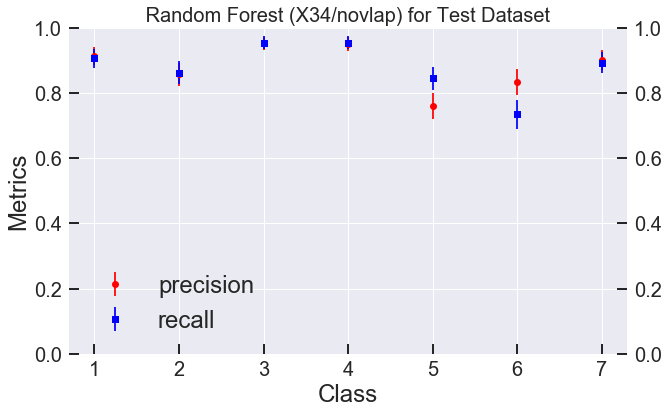

In [22]:
plot_score4each(rf_clf_cm)
#plt.yticks(np.arange(0,10,1)*0.1)
plt.title(" Random Forest (X34/novlap) for Test Dataset ", fontsize=20)

**Let's go back to check the scores for the training data**

[[1578    0    0    0    0    0    2]
 [   0 1451    0    0    5    2    0]
 [   0    2 1645    1    0    0    0]
 [   2    0    5 1561    0    0    1]
 [   0    5    0    0 1574    1    0]
 [   0    6    0    0   17 1446    0]
 [   2    0    1    1    0    0 1536]]


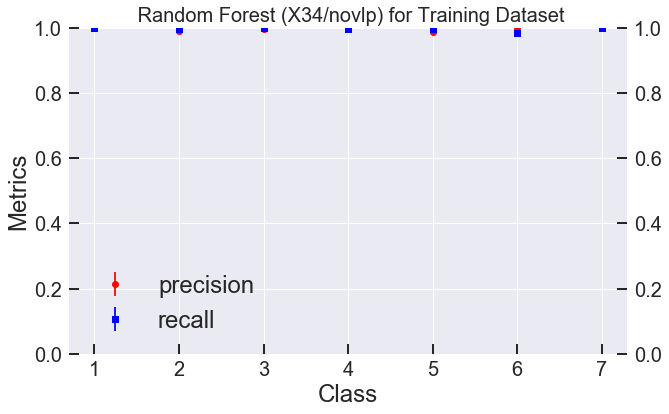

In [23]:
y_pred4train   = rf_clf.predict(X_train)        
rf_clf_cm4train = metrics.confusion_matrix(y_train,y_pred4train)

print(rf_clf_cm4train)
plot_score4each(rf_clf_cm4train)
plt.title(" Random Forest (X34/novlp) for Training Dataset", fontsize=20)
plt.legend(loc=3, fontsize=24)

([<matplotlib.axis.YTick at 0x13fc222b0>,
 <a list of 7 Text yticklabel objects>)

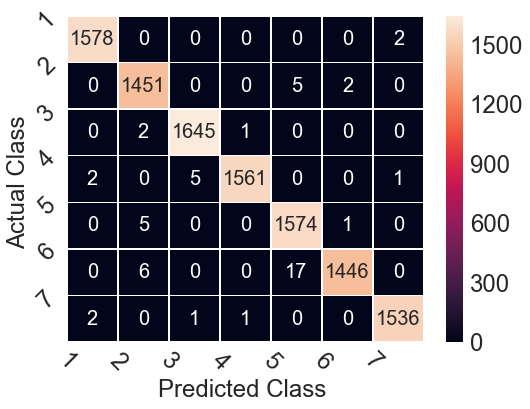

In [24]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2.4)
sns.heatmap(rf_clf_cm4train,annot=True,annot_kws={"size": 20}, linewidths=0.5,fmt='.0f');
plt.xlabel('Predicted Class ', fontsize=24)
plt.ylabel('Actual Class ', fontsize=24) 

# #set ticklabels rotation
width, height = rf_clf_cm.shape
alphabet = '1234567'
plt.xticks(range(width), alphabet[:width], fontsize=24, rotation=-45)
plt.yticks(range(height), alphabet[:height], fontsize=24, rotation=45) 

<font color='red'> Random Forest overfits the data ! </font>

Introduce regularization by 
- reducing "max_depth": max number of levels in each decision tree
- increasing "min_samples_split": min number of data points placed in a node before the node is split

 

from the best parameters (given by GrdiSearch):

    params_best = {
     'bootstrap': [True],
     'max_depth': [80],
     'max_features': [4],
     'min_samples_leaf': [2],
     'min_samples_split': [7],
     'n_estimators': [300]
     }
     
     
     
    Create the parameter grid based on the results of random search:
    
    param_grid = {
         'bootstrap': [True],
         'max_depth': [80, 90],
         'max_features': [2, 3, 4],
         'min_samples_leaf': [2, 3, 4],
         'min_samples_split': [7, 8, 10],
         'n_estimators': [100, 200, 300]
     }
 
The following parametrs are the best ones from the GridSearch:

    params_best = {
     'bootstrap': [True],
     'max_depth': [80],
     'max_features': [4],
     'min_samples_leaf': [2],
     'min_samples_split': [7],
     'n_estimators': [300]
     }

    grid_search = GridSearchCV(estimator = RandomForestClassifier(), 
                       param_grid = params_best,  
                       cv = 5, n_jobs = -1, verbose = 2)

    Fit the grid_search to the data:

    grid_search.fit(X_train, y_train) 
    grid_search.best_params_
      

In [25]:
# use the data with 34 features and no overlap between windows
X_train = X34_train_novlp
y_train = y34_train_novlp
X_test  = X34_test_novlp
y_test  = y34_test_novlp

In [122]:


metric_max=0

for n_estimators in range(200,500,100):
    for max_depth in range(8,20,2):
        for min_samples_split in range(20,30, 2):
            metric_max = check_overfitting_rf(X_train,y_train,X_test,y_test, \
                                              n_estimators, max_depth, min_samples_split,metric_max)

n_estimators: 200, max_depth:8, min_samples_split:20
f1(weighted)/Train:0.87, f1(weighted)/Test:0.84, metric:0.79
n_estimators: 200, max_depth:8, min_samples_split:22
f1(weighted)/Train:0.87, f1(weighted)/Test:0.84, metric:0.79
n_estimators: 200, max_depth:8, min_samples_split:26
f1(weighted)/Train:0.87, f1(weighted)/Test:0.84, metric:0.80


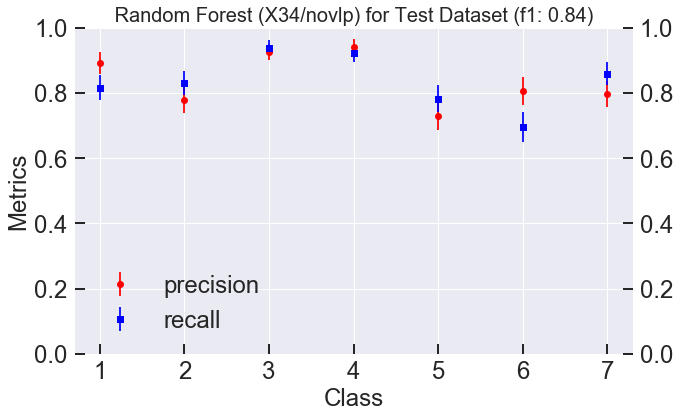

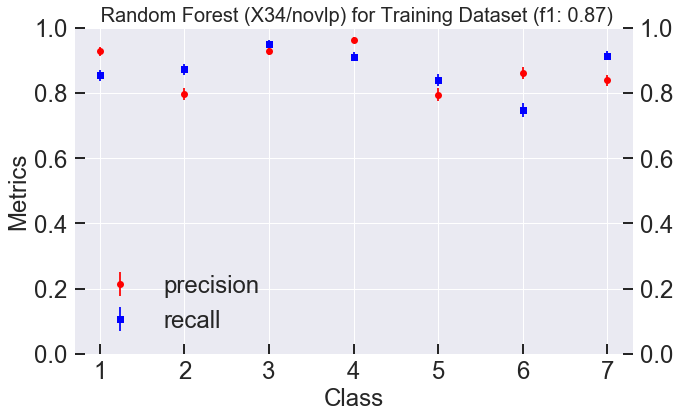

In [26]:
# we find the parameters which provide similar and high score for training and test data
n_estimators=200
max_depth= 8
min_samples_split=26


rf_clf = make_pipeline(RobustScaler(),
                        RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                        min_samples_split=min_samples_split)).fit(X=X_train, y=y_train)

y_pred4test   = rf_clf.predict(X_test)
y_pred4train   = rf_clf.predict(X_train)


rf_clf_cm4test = metrics.confusion_matrix(y_test,y_pred4test) 
rf_clf_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
plot_score4each(rf_clf_cm4test)
plt.title(" Random Forest (X34/novlp) for Test Dataset (f1: 0.84) ", fontsize=20)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

plot_score4each(rf_clf_cm4train)
plt.title(" Random Forest (X34/novlp) for Training Dataset (f1: 0.87)", fontsize=20)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)
plt.legend(loc=3)

### Using X34 data with half overlaping between windows

In [16]:
# use the data with 34 features and no overlap between windows
X_train = X34_train_ovlp
y_train = y34_train_ovlp
X_test  = X34_test_ovlp
y_test  = y34_test_ovlp

df4samples = segments_balanced_ovlp_df

In [129]:
GridSearch4rf = False

if GridSearch4rf:
    metric_max=0

    for n_estimators in range(200,500,100):
    for max_depth in range(8,20,2):
        for min_samples_split in range(20,30, 2):
            metric_max = check_overfitting_rf(X_train,y_train,X_test,y_test, \
                                               n_estimators,max_depth,min_samples_split,metric_max)

n_estimators: 200, max_depth:8, min_samples_split:20
f1(weighted)/Train:0.87, f1(weighted)/Test:0.84, metric:0.81
n_estimators: 200, max_depth:8, min_samples_split:22
f1(weighted)/Train:0.87, f1(weighted)/Test:0.85, metric:0.81
n_estimators: 200, max_depth:8, min_samples_split:24
f1(weighted)/Train:0.86, f1(weighted)/Test:0.84, metric:0.81
n_estimators: 200, max_depth:8, min_samples_split:26
f1(weighted)/Train:0.86, f1(weighted)/Test:0.84, metric:0.81
n_estimators: 200, max_depth:10, min_samples_split:20
f1(weighted)/Train:0.91, f1(weighted)/Test:0.88, metric:0.83
n_estimators: 200, max_depth:10, min_samples_split:26
f1(weighted)/Train:0.91, f1(weighted)/Test:0.88, metric:0.83
n_estimators: 200, max_depth:12, min_samples_split:20
f1(weighted)/Train:0.94, f1(weighted)/Test:0.89, metric:0.83
n_estimators: 200, max_depth:12, min_samples_split:22
f1(weighted)/Train:0.93, f1(weighted)/Test:0.89, metric:0.83
n_estimators: 200, max_depth:12, min_samples_split:28
f1(weighted)/Train:0.93, f1(we

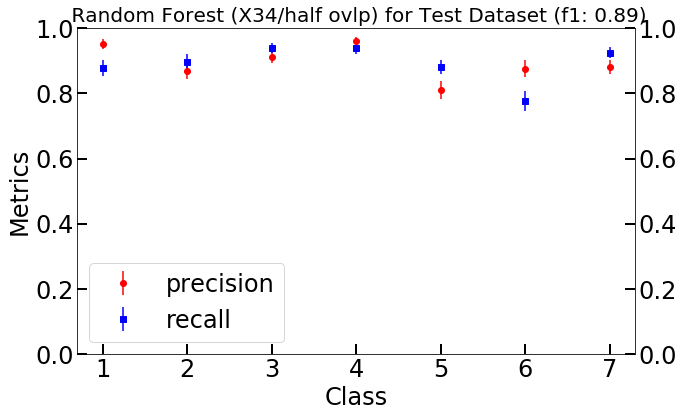

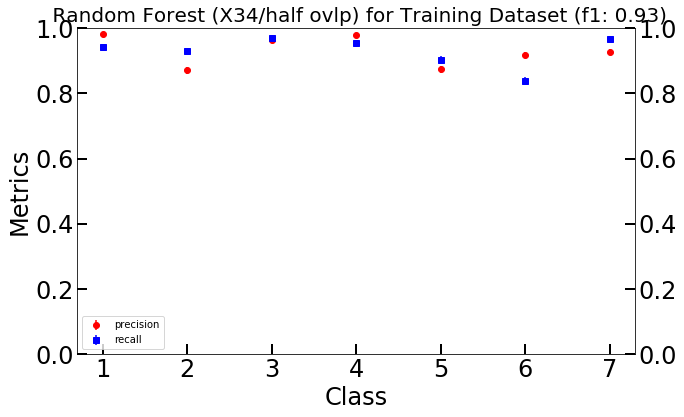

In [17]:
# we find the parameters which provide similar and high score for training and test data
max_depth=12
min_samples_split=28
n_estimators = 300


rf_clf_X34_best = make_pipeline(RobustScaler(),
                        RandomForestClassifier(
                            n_estimators = n_estimators, 
                            max_depth = max_depth,
                            min_samples_split = min_samples_split)).fit(X=X_train, y=y_train)

y_pred4test   = rf_clf_X34_best.predict(X_test)
y_pred4train   = rf_clf_X34_best.predict(X_train)


rf_clf_cm4test = metrics.confusion_matrix(y_test,y_pred4test) 
rf_clf_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
plot_score4each(rf_clf_cm4test)
plt.title(" Random Forest (X34/half ovlp) for Test Dataset (f1: 0.89)", fontsize=20)

plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)
plot_score4each(rf_clf_cm4train)
plt.title(" Random Forest (X34/half ovlp) for Training Dataset (f1: 0.93)", fontsize=20)
plt.legend(loc=3)

plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

In [18]:
print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


F1 score for Test: 0.8925483820427816
F1 score for Train: 0.9301023421034806


In [19]:
print_score4each(rf_clf_cm4test)

Label_p  precision  precision_Low  precision_Up    recall  recall_Low  \
0        1   0.950725       0.934575      0.966874  0.878179    0.854724   
1        2   0.869221       0.845203      0.893238  0.897681    0.875741   
2        3   0.911765       0.892697      0.930833  0.939394    0.923112   
3        4   0.960205       0.946478      0.973932  0.938519    0.921843   
4        5   0.810142       0.783745      0.836538  0.880769    0.858027   
5        6   0.876147       0.850900      0.901393  0.777476    0.747447   
6        7   0.880332       0.858435      0.902229  0.925280    0.907094   

   recall_Up  
0   0.901635  
1   0.919621  
2   0.955676  
3   0.955196  
4   0.903511  
5   0.807506  
6   0.943467

**The prediction score usin the half overlaping data is higher than that using the data without overlaping.**

In [132]:
print("No overlap versus half overlap: ")
stats, p_value = statistic_compare_two_models(0.84,0.89,
                                              len(X34_test_novlp),len(X34_test_ovlp),
                                              0.05,2)
print("stats={}, p value={}".format(stats,p_value))

No overlap versus half overlap: 
Reject H0: The performance of the two models is different at the confidence level of 95.0%
stats=6.390987150176129, p value=1.648182340313543e-10


### Using X25 data with half overlaping between windows

**The following part is based on the samples with 25 features (without frequency
domain features).**

In [133]:
X_train = X25_train_ovlp
y_train = y25_train_ovlp
X_test  = X25_test_ovlp
y_test  = y25_test_ovlp

In [134]:
metric_max=0

for n_estimators in range(200,500,100):
    for max_depth in range(8,20,2):
        for min_samples_split in range(20,30, 2):
            metric_max = check_overfitting_rf2(X_train,y_train,X_test,y_test, \
                                               n_estimators,max_depth,min_samples_split,metric_max)

n_estimators: 200, max_depth:8, min_samples_split:20
f1(weighted)/Train:0.73, f1(weighted)/Test:0.69, metric:0.63
n_estimators: 200, max_depth:10, min_samples_split:20
f1(weighted)/Train:0.81, f1(weighted)/Test:0.75, metric:0.67
n_estimators: 200, max_depth:10, min_samples_split:24
f1(weighted)/Train:0.80, f1(weighted)/Test:0.75, metric:0.67
n_estimators: 200, max_depth:12, min_samples_split:20
f1(weighted)/Train:0.87, f1(weighted)/Test:0.79, metric:0.68
n_estimators: 200, max_depth:12, min_samples_split:22
f1(weighted)/Train:0.86, f1(weighted)/Test:0.79, metric:0.68
n_estimators: 200, max_depth:12, min_samples_split:24
f1(weighted)/Train:0.86, f1(weighted)/Test:0.79, metric:0.69
n_estimators: 200, max_depth:12, min_samples_split:26
f1(weighted)/Train:0.86, f1(weighted)/Test:0.79, metric:0.69
n_estimators: 200, max_depth:14, min_samples_split:24
f1(weighted)/Train:0.89, f1(weighted)/Test:0.81, metric:0.69
n_estimators: 300, max_depth:12, min_samples_split:24
f1(weighted)/Train:0.86, f1

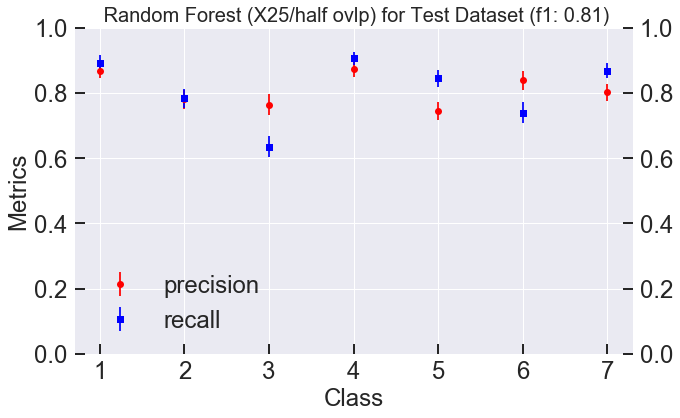

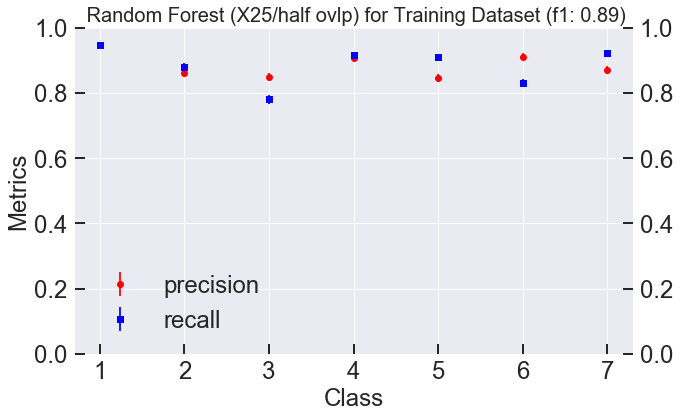

In [138]:
# we find the parameters which provide similar and high score for training and test data
max_depth =14
min_samples_split=28
n_estimators=300


rf_clf = make_pipeline(RobustScaler(),
                        RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                        min_samples_split=min_samples_split)).fit(X=X_train, y=y_train)

y_pred4test   = rf_clf.predict(X_test)
y_pred4train   = rf_clf.predict(X_train)

 

rf_clf_cm4test = metrics.confusion_matrix(y_test,y_pred4test) 
rf_clf_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
plot_score4each(rf_clf_cm4test)
plt.title(" Random Forest (X25/half ovlp) for Test Dataset (f1: 0.81)", fontsize=20)

plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

plot_score4each(rf_clf_cm4train)
plt.title(" Random Forest (X25/half ovlp) for Training Dataset (f1: 0.89)", fontsize=20)
plt.legend(loc=3)

plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

## Window Size effect

In [2]:
ratios = np.array([12, 1, 4, 7, 1, 1, 12]) 

time_interval = 1/52.0

sample_features = ['x_mean', 'y_mean', 'z_mean', 
             'x_var', 'y_var', 'z_var', 
             'x_max', 'y_max', 'z_max', 
             'x_min', 'y_min', 'z_min', 
             'x_mad', 'y_mad', 'z_mad',  # 15
             'magnitude',
            'corr_xy','corr_yz','corr_zx', # 19
             'skew_x','skew_y','skew_z',
             'kurt_x','kurt_y','kurt_z',   # 25
            'x_moment1','x_moment2','x_moment3',
            'y_moment1','y_moment2','y_moment3',
            'z_moment1','z_moment2','z_moment3',  # 34
             'label']

In [7]:

max_depth         = 13
min_samples_split = 34

overlap  = False

model = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

collection_results = [] 

for window_size in range(26, 260, 26):
    print(" Window_size: {}".format(window_size))
    collection_results.append(handcrafted_model(model, dfs, ratios, window_size, 
                                                sample_features, time_interval, overlap))
    
collection_results_dic = {}
for i in range(len(collection_results)):
    collection_results_dic[collection_results[i][0]] = collection_results[i][1] 

 Window_size: 26
class: 1, window_size: 312, step_size: 312, sample_size: 1950
class: 2, window_size: 26, step_size: 26, sample_size: 1841
class: 3, window_size: 104, step_size: 104, sample_size: 2084
class: 4, window_size: 182, step_size: 182, sample_size: 1961
class: 5, window_size: 26, step_size: 26, sample_size: 1980
class: 6, window_size: 26, step_size: 26, sample_size: 1837
class: 7, window_size: 312, step_size: 312, sample_size: 1902
(13555, 35) 35
 Window_size: 52
class: 1, window_size: 624, step_size: 624, sample_size: 975
class: 2, window_size: 52, step_size: 52, sample_size: 920
class: 3, window_size: 208, step_size: 208, sample_size: 1042
class: 4, window_size: 364, step_size: 364, sample_size: 980
class: 5, window_size: 52, step_size: 52, sample_size: 990
class: 6, window_size: 52, step_size: 52, sample_size: 918
class: 7, window_size: 624, step_size: 624, sample_size: 951
(6776, 35) 35
 Window_size: 78
class: 1, window_size: 936, step_size: 936, sample_size: 650
class: 2,

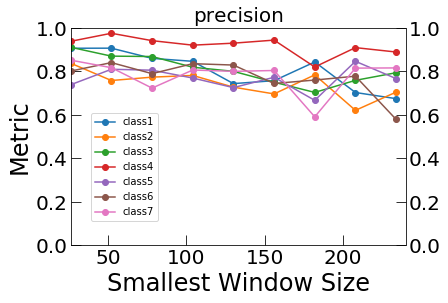

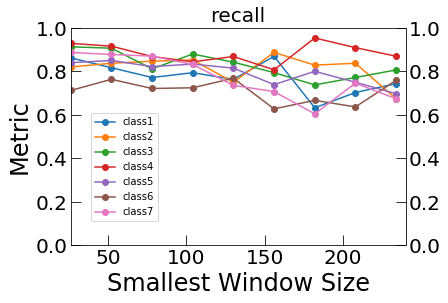

In [38]:
metrics = ['precision', 'recall']

for metric in metrics:
    results_dfs4metric = []

    for key in collection_results_dic:  
        results_dfs4metric.append(pd.DataFrame(print_score4each(collection_results_dic[key]).T.loc[metric]).T)
    
    df4metric = pd.concat(results_dfs4metric[i] for i in range(0,len(results_dfs4metric)))
    df4metric.columns=['class1', 'class2', 'class3','class4','class5','class6','class7']
    df4metric = df4metric.reset_index()
    df4metric['window_size'] = (df4metric.index+1)*26
    
    for i in range(1,8):
        plt.plot(df4metric['window_size'], df4metric['class'+str(i)],'-o',label='class'+str(i))
    plt.title(metric, fontsize=20)
    set_figstyle(26,240,0,1,'Smallest Window Size','Metric',True)
    
    plt.legend(bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=2.) 
    plt.show()

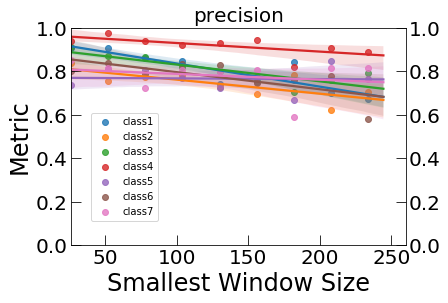

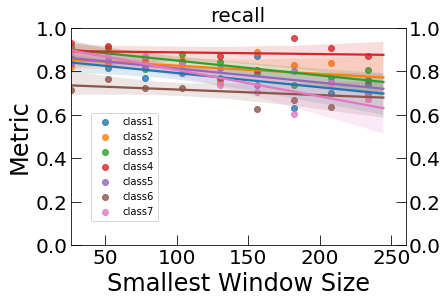

In [34]:
metrics = ['precision', 'recall']

for metric in metrics:
    results_dfs4metric = []

    for key in collection_results_dic:  
        results_dfs4metric.append(pd.DataFrame(print_score4each(collection_results_dic[key]).T.loc[metric]).T)
    
    df4metric = pd.concat(results_dfs4metric[i] for i in range(0,len(results_dfs4metric)))
    df4metric.columns=['class1', 'class2', 'class3','class4','class5','class6','class7']
    df4metric = df4metric.reset_index()
    df4metric['window_size'] = (df4metric.index+1)*26
    
    for i in range(1,8):
        sns.regplot(x='window_size', y='class'+str(i),data=df4metric,label='class'+str(i))
    plt.title(metric, fontsize=20)
    set_figstyle(26,260,0,1,'Smallest Window Size','Metric',True)
    plt.legend(bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=2.)
    plt.show()

In [5]:

max_depth         = 13
min_samples_split = 34

overlap  = True

model = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

collection_results = [] 

for window_size in range(26, 260, 26):
    print(" Window_size: {}".format(window_size))
    collection_results.append(handcrafted_model(model, dfs, ratios, window_size, 
                                                sample_features, time_interval, overlap))
    
collection_results_dic = {}
for i in range(len(collection_results)):
    collection_results_dic[collection_results[i][0]] = collection_results[i][1] 

 Window_size: 26
class: 1, window_size: 312, step_size: 157, sample_size: 3875
class: 2, window_size: 26, step_size: 14, sample_size: 3418
class: 3, window_size: 104, step_size: 53, sample_size: 4088
class: 4, window_size: 182, step_size: 92, sample_size: 3880
class: 5, window_size: 26, step_size: 14, sample_size: 3677
class: 6, window_size: 26, step_size: 14, sample_size: 3411
class: 7, window_size: 312, step_size: 157, sample_size: 3779
(26128, 35) 35
 Window_size: 52
class: 1, window_size: 624, step_size: 313, sample_size: 1943
class: 2, window_size: 52, step_size: 27, sample_size: 1772
class: 3, window_size: 208, step_size: 105, sample_size: 2063
class: 4, window_size: 364, step_size: 183, sample_size: 1950
class: 5, window_size: 52, step_size: 27, sample_size: 1906
class: 6, window_size: 52, step_size: 27, sample_size: 1768
class: 7, window_size: 624, step_size: 313, sample_size: 1895
(13297, 35) 35
 Window_size: 78
class: 1, window_size: 936, step_size: 469, sample_size: 1296
cla

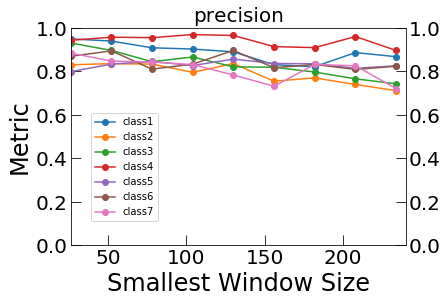

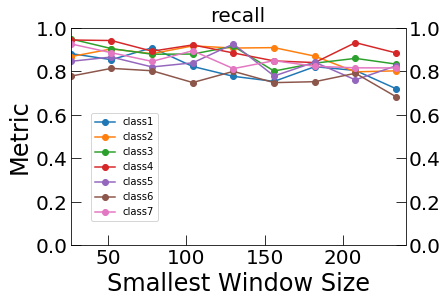

In [6]:
metrics = ['precision', 'recall']

for metric in metrics:
    results_dfs4metric = []

    for key in collection_results_dic:  
        results_dfs4metric.append(pd.DataFrame(print_score4each(collection_results_dic[key]).T.loc[metric]).T)
    
    df4metric = pd.concat(results_dfs4metric[i] for i in range(0,len(results_dfs4metric)))
    df4metric.columns=['class1', 'class2', 'class3','class4','class5','class6','class7']
    df4metric = df4metric.reset_index()
    df4metric['window_size'] = (df4metric.index+1)*26
    
    for i in range(1,8):
        plt.plot(df4metric['window_size'], df4metric['class'+str(i)],'-o',label='class'+str(i))
    plt.title(metric, fontsize=20)
    set_figstyle(26,240,0,1,'Smallest Window Size','Metric',True)
    
    plt.legend(bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=2.) 
    plt.show()

##  KNeighborsClassifier (KNN) 


In this section, I will try to use  a non parametric and instance-based learning algorithm: the KNN classifier, the pros of which is as follows: 

- Non-parametric:  no explicit assumptions about the functional form, avoiding the dangers of mismodeling the underlying distribution of the data. 
- Instance-based learning:  algorithm doesn’t explicitly learn a model. It memorizes the training instances which are subsequently used as “knowledge” for the prediction phase. 

In [20]:
X_train = X34_train_ovlp
y_train = y34_train_ovlp
X_test  = X34_test_ovlp
y_test  = y34_test_ovlp

In [52]:
# from sklearn.neighbors import KNeighborsClassifier

knn_clf = make_pipeline(RobustScaler(),
                   KNeighborsClassifier()).fit(X=X_train, y=y_train)
y_pred = knn_clf.predict(X_test)      
knn_clf_cm = metrics.confusion_matrix(y_test,y_pred)
print_scores(knn_clf_cm,y_test,y_pred)

accuracy: 0.811
precision:  0.807
recall:  0.808
F1 score (macro):  0.808
F1 score (weighted): 0.810


Text(0.5,1,' KNN (34 features) ')

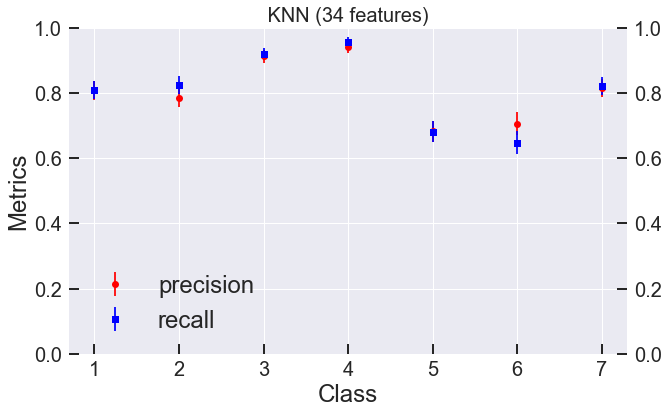

In [47]:

plot_score4each(knn_clf_cm)
plt.title(" KNN (34 features) ", fontsize=20)

In [147]:
n_neighbors_range = range(2,20,1) 
knn_clf_results, knn_clf_best,  \
knn_clf_best_cm, knn_clf_best_parameter = knn_gridsearch(X_train,y_train,X_test,y_test,n_neighbors_range)


k: 2, F1_score: 0.7871228672012442, accuracy: 0.7914053854666175
k: 3, F1_score: 0.8062426067913065, accuracy: 0.8068978236812984
k: 5, F1_score: 0.8097544235870737, accuracy: 0.8107709332349686
k: 9, F1_score: 0.8110417739282081, accuracy: 0.8116931021763187


In [157]:
knn_clf_results_df = pd.DataFrame(knn_clf_results)
knn_clf_results_df.columns=['k','F1','Accuracy']


Text(0.5,1,'KNN (X34/ovlp) for Test Dataset')

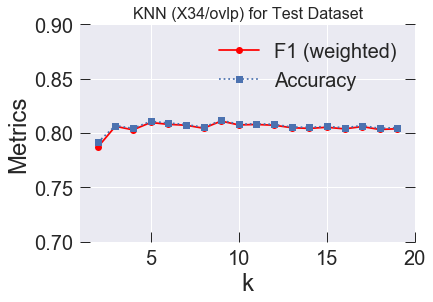

In [165]:
plt.plot(knn_clf_results_df['k'], knn_clf_results_df['F1'],'-o' ,c='r',label='F1 (weighted)')
plt.plot(knn_clf_results_df['k'], knn_clf_results_df['Accuracy'], ':s', label='Accuracy')
set_figstyle(1,20,0.7,0.9,'k','Metrics',False)
plt.legend(fontsize=20)
plt.title('KNN (X34/ovlp) for Test Dataset', fontsize=16)

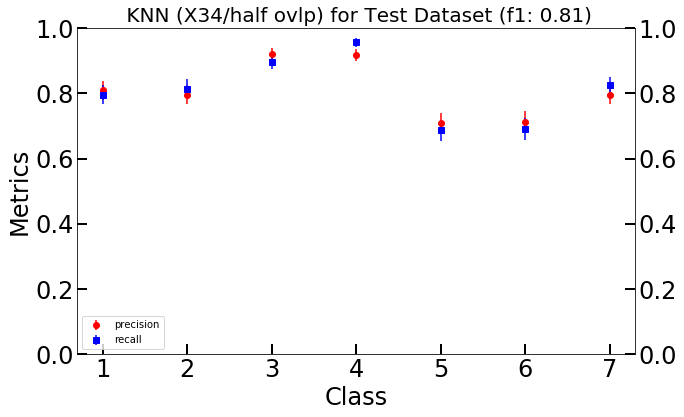

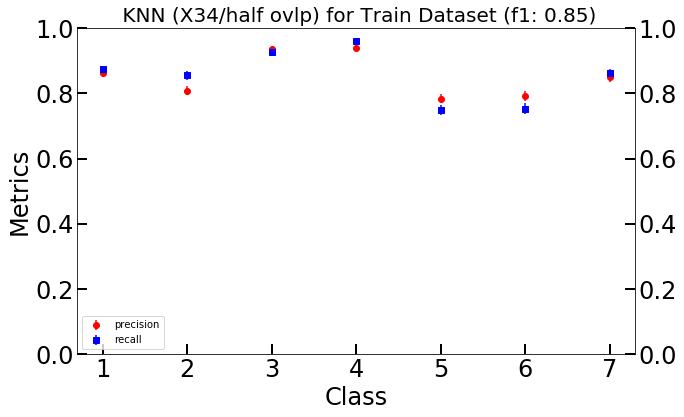

In [21]:
knn_clf = make_pipeline(RobustScaler(),
                   KNeighborsClassifier(n_neighbors = 9)).fit(X=X_train, y=y_train) 

y_pred4test   = knn_clf.predict(X_test)
y_pred4train   = knn_clf.predict(X_train)


knn_clf_cm4test = metrics.confusion_matrix(y_test,y_pred4test) 
knn_clf_cm4train = metrics.confusion_matrix(y_train,y_pred4train)

plot_score4each(knn_clf_cm4test)
plt.title(" KNN (X34/half ovlp) for Test Dataset (f1: 0.81)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(knn_clf_cm4train)
plt.title(" KNN (X34/half ovlp) for Train Dataset (f1: 0.85)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

In [22]:
print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))

F1 score for Test: 0.8110417739282081
F1 score for Train: 0.854657647035538


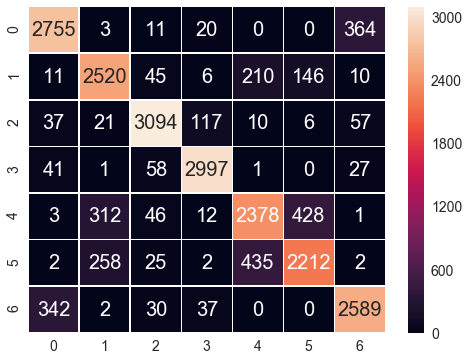

In [74]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(knn_clf_best_cm4train,annot=True,
            annot_kws={"size": 20}, linewidths=0.5,fmt='.0f');

## Support Vector Machine

In [24]:
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import PolynomialFeatures

X_train = X34_train_ovlp
y_train = y34_train_ovlp
X_test  = X34_test_ovlp
y_test  = y34_test_ovlp

In [172]:


# gridsearch (time consuming)

def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 1, 10] # penalty parameter of the error term. 
    gammas = [0.1, 1, 10]  # degree for poly
    param_grid = {'C': Cs, 'gamma' : gammas}
    
    rbf_grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    rbf_grid_search.fit(X, y) 
    
    return rbf_grid_search.best_params_




In [173]:
#caution: extremely time consuming part
svm_rbf_best_parameter = svc_param_selection(X_train, y_train, 5)  
svm_rbf_best_parameter

{'C': 10, 'gamma': 0.1}

In [180]:
# C=1, gamma=0.1
svm_clf_rbf_best = make_pipeline(RobustScaler(),
                           SVC(kernel="rbf", C=1, gamma=0.1)).fit(X=X_train, y=y_train)

y_pred4test        = svm_clf_rbf_best.predict(X_test)
y_pred4train       = svm_clf_rbf_best.predict(X_train)

print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))

F1 score for Test: 0.8450822946616705
F1 score for Train: 0.9093961379382896


In [178]:
# C=10, gamma=0.1

svm_clf_rbf_best = make_pipeline(RobustScaler(),
                           SVC(kernel="rbf", C=10, gamma=0.1)).fit(X=X_train, y=y_train)

y_pred4test        = svm_clf_rbf_best.predict(X_test)
y_pred4train       = svm_clf_rbf_best.predict(X_train)

print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))

F1 score for Test: 0.8665279848729349
F1 score for Train: 0.9648337080539436


In [179]:
# # C=100, gamma=0.1

svm_clf_rbf_best = make_pipeline(RobustScaler(),
                           SVC(kernel="rbf", C=100, gamma=0.1)).fit(X=X_train, y=y_train)

y_pred4test        = svm_clf_rbf_best.predict(X_test)
y_pred4train       = svm_clf_rbf_best.predict(X_train)

print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))

F1 score for Test: 0.8616483026011749
F1 score for Train: 0.9916923955497672


**Choose more proper parameters **

In [25]:
svm_clf_rbf_best = make_pipeline(RobustScaler(),
                           SVC(kernel="rbf", C=1, gamma=0.1)).fit(X=X_train, y=y_train)

In [26]:

y_pred4test        = svm_clf_rbf_best.predict(X_test)
y_pred4train       = svm_clf_rbf_best.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


svm_clf_rbf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
svm_clf_rbf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
  


F1 score for Test: 0.8450822946616705
F1 score for Train: 0.9093961379382896


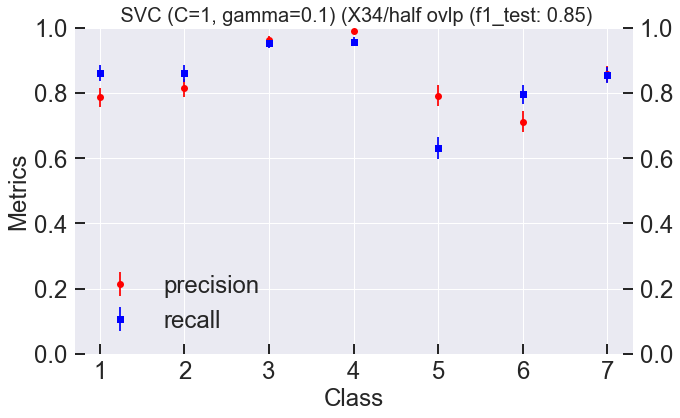

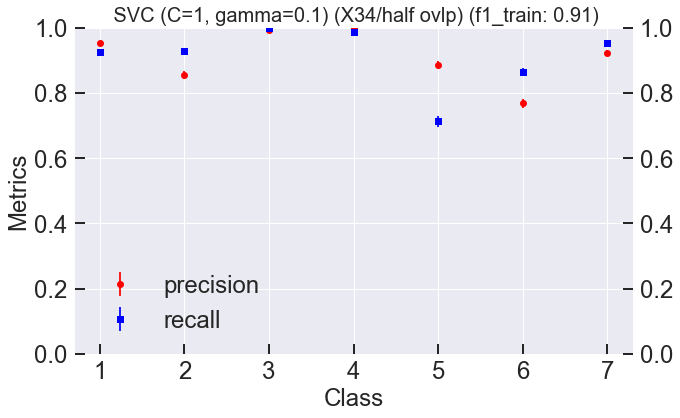

In [185]:

plot_score4each(svm_clf_rbf_best_cm4test) 
plt.title(" SVC (C=1, gamma=0.1) (X34/half ovlp (f1_test: 0.85)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(svm_clf_rbf_best_cm4train) 
plt.title(" SVC (C=1, gamma=0.1) (X34/half ovlp) (f1_train: 0.91)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

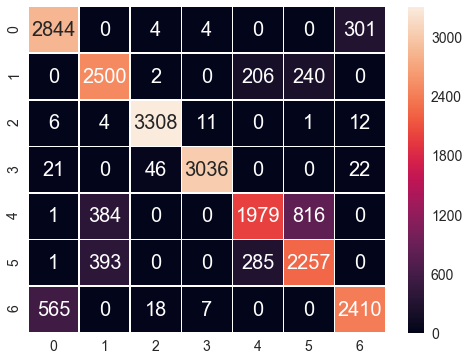

In [73]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(svm_clf_rbf_best_cm4train,annot=True,
            annot_kws={"size": 20}, linewidths=0.5,fmt='.0f');

## Ensemble methods

### Voting method

- Train a few classfiers (based on different algorithms) 
- and aggregate the predictions of each classifier
- and predict the class that gets the most votes.
- The ensemble can do much better than each classifer, provided that the classifiers are independent.

In [29]:
X_train = X34_train_ovlp
y_train = y34_train_ovlp
X_test  = X34_test_ovlp
y_test  = y34_test_ovlp

In [35]:
from sklearn.ensemble import VotingClassifier

# Take all the best cases for several different algorithms
svc_clf   = svm_clf_rbf_best 
neigh_clf = knn_clf
rnd_clf   = rf_clf_X34_best

voting_clf = make_pipeline(RobustScaler(), 
            VotingClassifier(estimators=[('svc',svc_clf), 
                                         ('rf',rnd_clf),
                                         ('neigh',neigh_clf)], voting='hard')).fit(X_train,y_train)


# voting = 'soft' only applys for the estimators which predict probabilities.

In [36]:

y_pred4test        = voting_clf.predict(X_test)
y_pred4train       = voting_clf.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


voting_clf_rbf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
voting_clf_rbf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
  



F1 score for Test: 0.8664593078504613
F1 score for Train: 0.9222938355969531


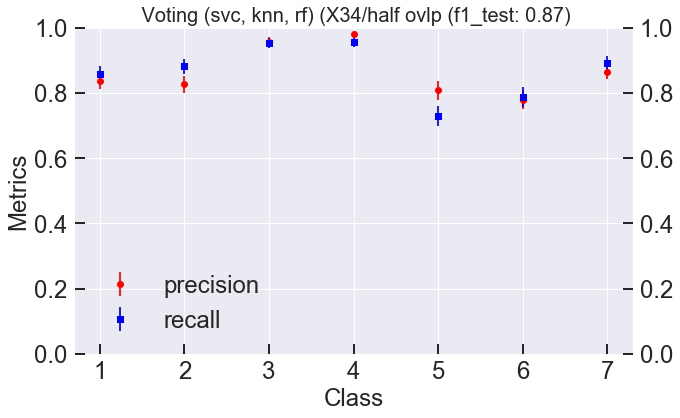

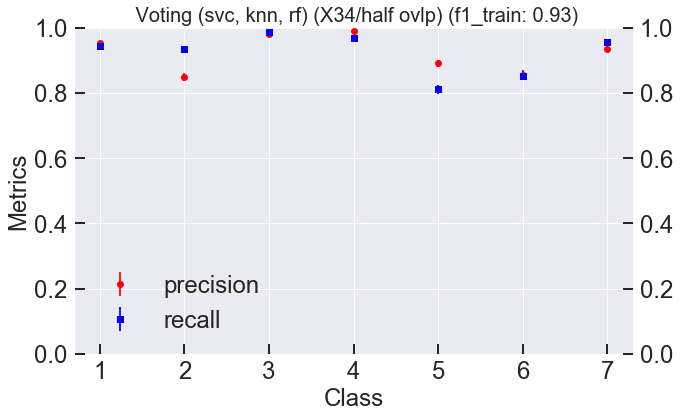

In [195]:

plot_score4each(voting_clf_rbf_best_cm4test) 
plt.title(" Voting (svc, knn, rf) (X34/half ovlp (f1_test: 0.87)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(voting_clf_rbf_best_cm4train) 
plt.title(" Voting (svc, knn, rf) (X34/half ovlp) (f1_train: 0.93)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

### Bagging method

Here I will use the best Random Forest classifier (rf_clf_best) in the Bagging method to train on $n\_estimators=20$ different random subsets of the training set. The use of bootstrap introduces more diversity in the subsets.

In [37]:
from sklearn.ensemble import BaggingClassifier

bag_clf = make_pipeline(RobustScaler(), 
                        BaggingClassifier(rf_clf_X34_best, n_estimators=20,
                            bootstrap=True, n_jobs=-1)).fit(X_train,y_train)
 

In [38]:

y_pred4test        = bag_clf.predict(X_test)
y_pred4train       = bag_clf.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


bag_clf_rbf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
bag_clf_rbf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
  




F1 score for Test: 0.8899437358287093
F1 score for Train: 0.9265091289905405


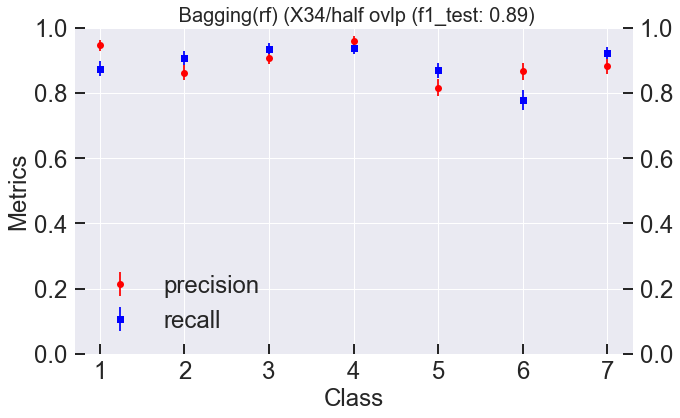

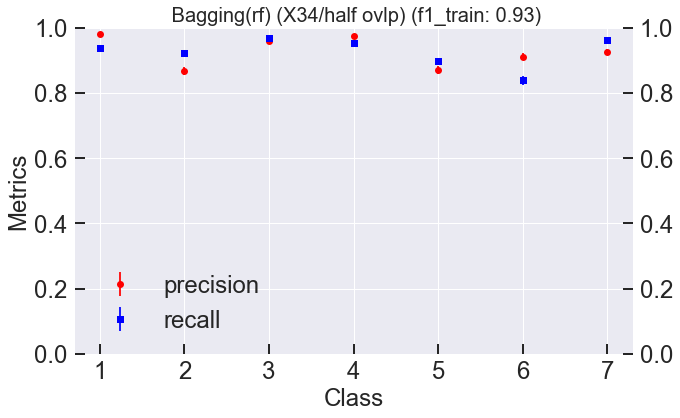

In [79]:

plot_score4each(bag_clf_rbf_best_cm4test) 
plt.title(" Bagging(rf) (X34/half ovlp (f1_test: 0.89)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(bag_clf_rbf_best_cm4train) 
plt.title(" Bagging(rf) (X34/half ovlp) (f1_train: 0.93)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

### Gradient Boosting

- sequentially adding predictors to an ensemble, each one correcting its predecessor.
- The new predictor is fitted to the residual errors in the previous prediction.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = make_pipeline(RobustScaler(), 
                        GradientBoostingClassifier( 
                            max_depth = 90,
                            min_samples_leaf=2,
                            n_estimators=200,
                            learning_rate=1.0)).fit(X_train,y_train)
 

In [200]:

y_pred4test        = gb_clf.predict(X_test)
y_pred4train       = gb_clf.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


gb_clf_rbf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
gb_clf_rbf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
  





F1 score for Test: 0.8963221867764687
F1 score for Train: 1.0


**Overfit the data**

**GridSearch parameters which do not overfit the data**

In [203]:
metric_max=0

for n_estimators in range(100,300,100):
    for max_depth in range(8,20,4):
        for min_samples_split in range(10,30, 10):
            metric_max = check_overfitting_gb(X_train,y_train,X_test,y_test, \
                                               n_estimators,max_depth,min_samples_split,metric_max)
            

n_estimators: 100, max_depth:8, min_samples_split:10
f1(weighted)/Train:1.00, f1(weighted)/Test:0.92, metric:0.79
n_estimators: 100, max_depth:8, min_samples_split:20
f1(weighted)/Train:1.00, f1(weighted)/Test:0.92, metric:0.80
n_estimators: 100, max_depth:12, min_samples_split:10
f1(weighted)/Train:1.00, f1(weighted)/Test:0.92, metric:0.81
n_estimators: 100, max_depth:16, min_samples_split:20
f1(weighted)/Train:1.00, f1(weighted)/Test:0.93, metric:0.82
n_estimators: 200, max_depth:8, min_samples_split:20
f1(weighted)/Train:1.00, f1(weighted)/Test:0.93, metric:0.82


In [1]:
gb_clf_best = make_pipeline(RobustScaler(), 
                        GradientBoostingClassifier( 
                            max_depth = 8,
                            min_samples_split=20,
                            n_estimators=200)).fit(X_train,y_train)

In [ ]:

y_pred4test        = gb_clf_best.predict(X_test)
y_pred4train       = gb_clf_best.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted')))


gb_clf_rbf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
gb_clf_rbf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)
  


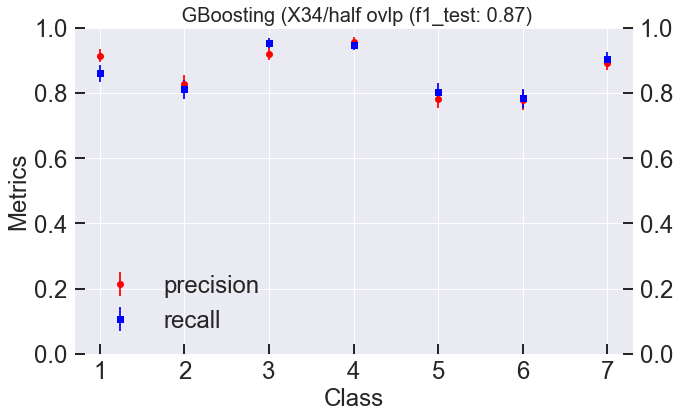

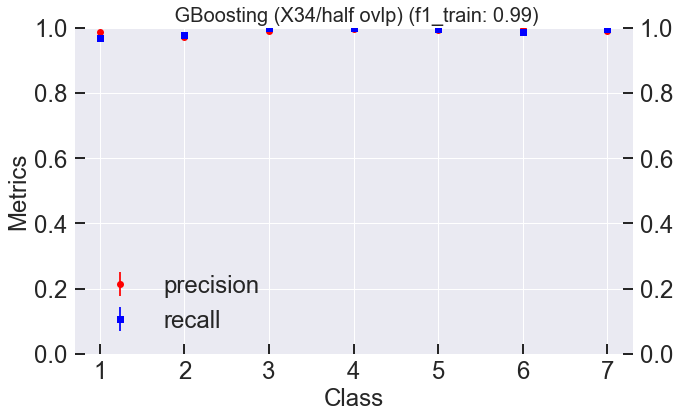

In [209]:
plot_score4each(gb_clf_rbf_best_cm4test) 
plt.title(" GBoosting (X34/half ovlp (f1_test: 0.87)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(gb_clf_rbf_best_cm4train) 
plt.title(" GBoosting (X34/half ovlp) (f1_train: 0.99)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

In [27]:
from sklearn.metrics import mean_squared_error

In [41]:
gbrt = GradientBoostingClassifier(max_depth=8, n_estimators=300, min_samples_split=20).fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)


In [42]:
gbrt_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

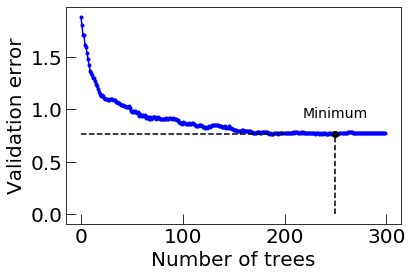

In [43]:
min_error = np.min(errors)

plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 200], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
#plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees", fontsize=20) 
plt.ylabel("Validation error", fontsize=20)


plt.tick_params(which='major',direction='in',length=10,labelsize=20)
plt.tick_params(which='minor',direction='in',length=5,labelsize=20)

**XGBoost (eXtreme Gradient Boosting)**

- an implementation of gradient boosted decision trees designed for speed and performance.
- dominates structured or tabular datasets on classification and regression predictive modeling problems.

In [52]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [47]:
X_train = X34_train_ovlp
y_train = y34_train_ovlp
X_test  = X34_test_ovlp
y_test  = y34_test_ovlp

In [48]:
def xgboost_fit_predict(X_train,y_train,X_test,y_test):
    
    xgb_clf = xgb.XGBClassifier(n_estimators=700, random_state=42) 
    
    eval_set = [[X_train, y_train],[X_test, y_test]]
    xgb_clf = xgb_clf.fit(X_train, y_train, 
                          eval_metric = ["mlogloss"],
                          eval_set    = eval_set, 
                          verbose     = 50,
                          early_stopping_rounds=2) # control overfitting
    return xgb_clf

In [49]:
xgb_clf = xgboost_fit_predict(X_train,y_train,X_test,y_test)

[0]	validation_0-mlogloss:1.78375	validation_1-mlogloss:1.78445
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 2 rounds.
[50]	validation_0-mlogloss:0.507429	validation_1-mlogloss:0.534661
[100]	validation_0-mlogloss:0.358646	validation_1-mlogloss:0.397919
[150]	validation_0-mlogloss:0.285447	validation_1-mlogloss:0.332257
[200]	validation_0-mlogloss:0.238271	validation_1-mlogloss:0.291979
[250]	validation_0-mlogloss:0.205363	validation_1-mlogloss:0.266081
[300]	validation_0-mlogloss:0.180903	validation_1-mlogloss:0.248416
[350]	validation_0-mlogloss:0.161489	validation_1-mlogloss:0.23577
[400]	validation_0-mlogloss:0.14448	validation_1-mlogloss:0.225716
[450]	validation_0-mlogloss:0.130191	validation_1-mlogloss:0.217504
[500]	validation_0-mlogloss:0.117736	validation_1-mlogloss:0.210965
[550]	validation_0-mlogloss:0.107171	validation_1-mlogloss:0.205529
[600]	validation_0-mloglo

In [50]:
model = xgb_clf

In [53]:
y_pred4test  = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred4test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 92.95%


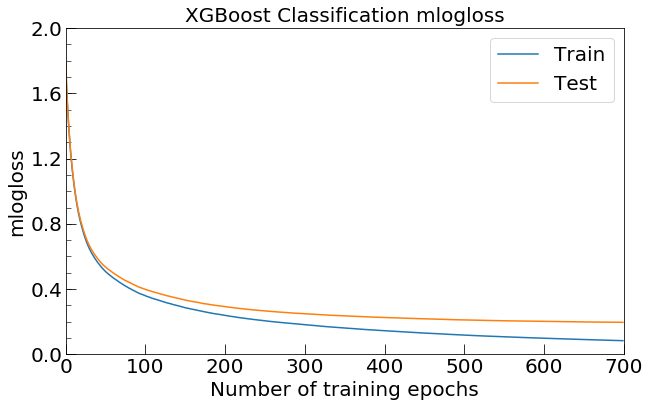

In [57]:

#predictions = [round(value) for value in y_pred4test]
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs) 
# plot classification error

plt.figure(figsize=(10,6))
ax = plt.gca()

ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend(fontsize=20)
plt.ylabel('mlogloss', fontsize=20)
plt.title('XGBoost Classification mlogloss', fontsize=20)
plt.xlabel('Number of training epochs', fontsize=20)

plt.tick_params(which='major',direction='in',length=10,labelsize=20)
plt.tick_params(which='minor',direction='in',length=5,labelsize=20)

plt.ylim(0,2)
plt.xlim(0,700)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.4))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) 

plt.show()

In [58]:

y_pred4test        = model.predict(X_test)
y_pred4train       = model.predict(X_train)

xgb_clf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
xgb_clf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)

print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted'))) 

F1 score for Test: 0.9295100595600019
F1 score for Train: 0.9833025070950081


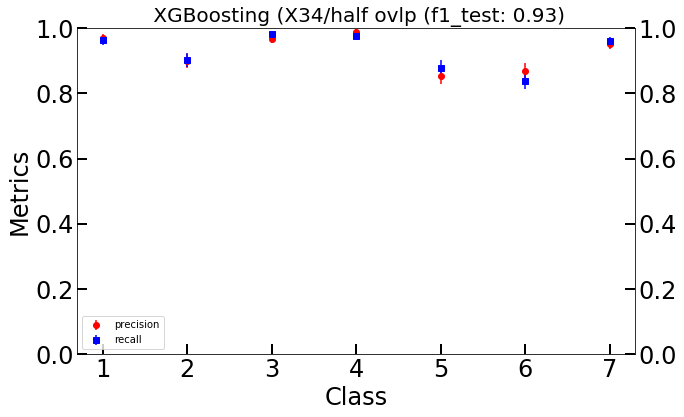

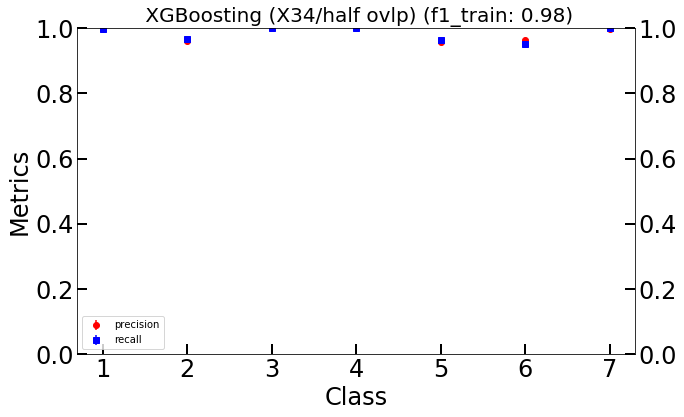

In [60]:
plot_score4each(xgb_clf_best_cm4test) 
plt.title(" XGBoosting (X34/half ovlp (f1_test: 0.93)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(xgb_clf_best_cm4train) 
plt.title(" XGBoosting (X34/half ovlp) (f1_train: 0.98)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

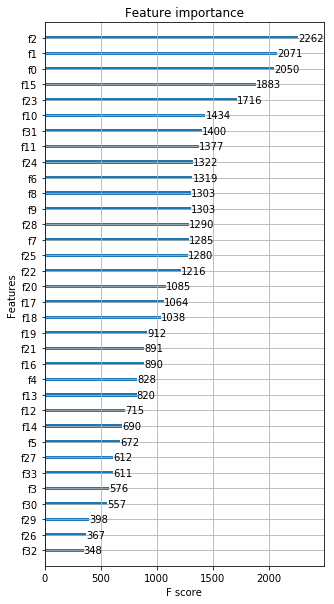

In [53]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5,20]
plt.show()

**Fine tuning parameters**

In [48]:
# xgb_reg = XGBClassifier(silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
#                       colsample_bytree = 0.4,
#                       subsample = 0.8, 
#                       n_estimators=1000, 
#                       reg_alpha = 0.3,
#                       max_depth=4, 
#                       gamma=10).fit(X_train, y_train)

# y_pred = xgb_reg.predict(X_test)
# val_error = mean_squared_error(y_test, y_pred)
# print("Validation MSE:", val_error)

In [62]:
# y_pred4test        = xgb_reg.predict(X_test)
# y_pred4train       = xgb_reg.predict(X_train)


# print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
# print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted'))) 



F1 score for Test: 0.8695317449019482
F1 score for Train: 0.8914360776963961


In [49]:

# xgb_clf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
# xgb_clf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)

# plot_score4each(xgb_clf_best_cm4test) 
# plt.title(" XGBoosting (X34/half ovlp (f1_test: 0.87)", fontsize=20)
# plt.legend(loc=3)
# plt.tick_params(which='major',direction='in',length=10,labelsize=24)
# plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


# plot_score4each(xgb_clf_best_cm4train) 
# plt.title(" XGBoosting (X34/half ovlp) (f1_train: 0.89)", fontsize=20)
# plt.legend(loc=3)
# plt.tick_params(which='major',direction='in',length=10,labelsize=24)
# plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

In [66]:
xgb_reg = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softmax',
     nthread=4,
     scale_pos_weight=1,
     seed=27).fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
val_error = mean_squared_error(y_test, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.6516045739579491


In [67]:
y_pred4test        = xgb_reg.predict(X_test)
y_pred4train       = xgb_reg.predict(X_train)


print("F1 score for Test: {}".format(f1_score(y_test,y_pred4test,average='weighted')))
print("F1 score for Train: {}".format(f1_score(y_train,y_pred4train,average='weighted'))) 


F1 score for Test: 0.9353087513544551
F1 score for Train: 1.0


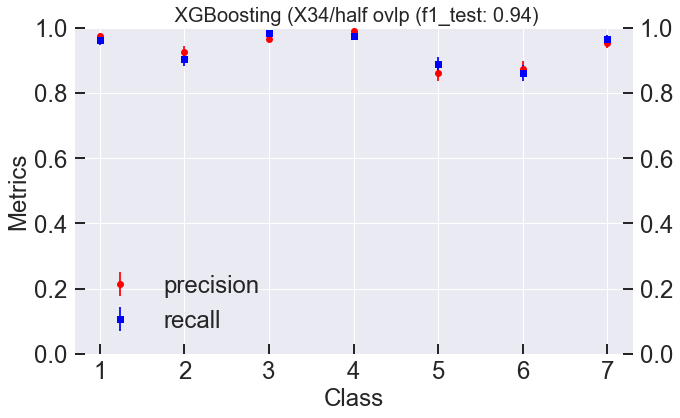

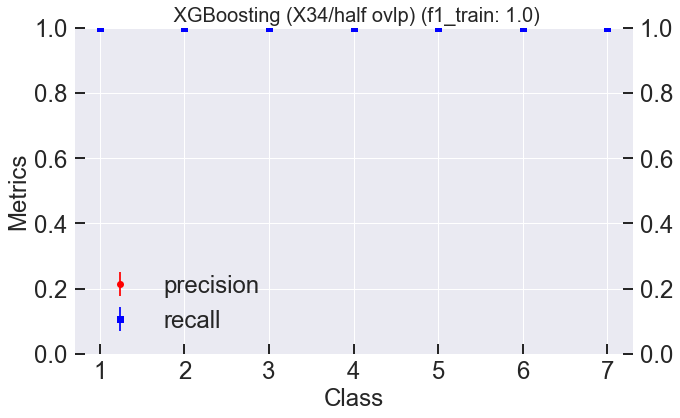

In [69]:

xgb_clf_best_cm4test = metrics.confusion_matrix(y_test,y_pred4test)
xgb_clf_best_cm4train = metrics.confusion_matrix(y_train,y_pred4train)

plot_score4each(xgb_clf_best_cm4test) 
plt.title(" XGBoosting (X34/half ovlp (f1_test: 0.94)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)


plot_score4each(xgb_clf_best_cm4train) 
plt.title(" XGBoosting (X34/half ovlp) (f1_train: 1.0)", fontsize=20)
plt.legend(loc=3)
plt.tick_params(which='major',direction='in',length=10,labelsize=24)
plt.tick_params(which='minor',direction='in',length=5,labelsize=24)

# Model comparison

In [61]:
# random forest
score_rf = print_score4each(rf_clf_cm4test)

In [62]:
df_score = score_rf[['Label_p','precision','recall']]
df_score['model'] = 'rf'
df_score

Label_p  precision    recall model
0        1   0.950725  0.878179    rf
1        2   0.869221  0.897681    rf
2        3   0.911765  0.939394    rf
3        4   0.960205  0.938519    rf
4        5   0.810142  0.880769    rf
5        6   0.876147  0.777476    rf
6        7   0.880332  0.925280    rf

In [63]:
# knn with k=9

score_knn = print_score4each(knn_clf_cm4test)

In [64]:
# svc with C=1, gamma=0.1

score_svm = print_score4each(svm_clf_rbf_best_cm4test)

In [65]:
# voting
score_voting = print_score4each(voting_clf_rbf_best_cm4test)

In [66]:
# bagging
score_bagging = print_score4each(bag_clf_rbf_best_cm4test)

In [67]:
# xgboost

score_xgb = print_score4each(xgb_clf_best_cm4test)

In [68]:
score_xgb

Label_p  precision  precision_Low  precision_Up    recall  recall_Low  \
0        1   0.969003       0.956533      0.981473  0.962517    0.948896   
1        2   0.900545       0.878895      0.922195  0.901774    0.880228   
2        3   0.967703       0.955720      0.979687  0.980606    0.971196   
3        4   0.988550       0.981112      0.995987  0.974906    0.964047   
4        5   0.853051       0.828563      0.877539  0.878205    0.855254   
5        6   0.869198       0.844414      0.893983  0.838535    0.811969   
6        7   0.951852       0.937109      0.966595  0.960149    0.946620   

   recall_Up  
0   0.976138  
1   0.923319  
2   0.990016  
3   0.985765  
4   0.901157  
5   0.865100  
6   0.973679

In [69]:
scores4all = [score_knn, score_svm, score_rf, score_voting, score_bagging, score_xgb]

In [70]:
len(scores4all)

6

In [71]:
xfeatures = ['Label_p','precision','recall']
models = ['knn', 'svm', 'rf', 'voting', 'bagging', 'xgb']

i = 0

for i in range(0,len(scores4all)):
    
    score_model = scores4all[i]
    print(i,  models[i])
    
    df_score = score_model[xfeatures]
    df_score['model'] = models[i]
     
    
    if i == 0:
        score_dfs = df_score
    else:
        score_dfs =pd.concat([score_dfs,df_score])
    
    i  +=1
    


0 knn
1 svm
2 rf
3 voting
4 bagging
5 xgb


In [72]:
score_dfs.head()

Label_p  precision    recall model
0        1   0.809524  0.796519   knn
1        2   0.796000  0.814461   knn
2        3   0.921544  0.896970   knn
3        4   0.918072  0.956085   knn
4        5   0.708058  0.687179   knn

In [73]:
score_dfs.to_csv('final_scores_of_each_model_4_each_class.csv')

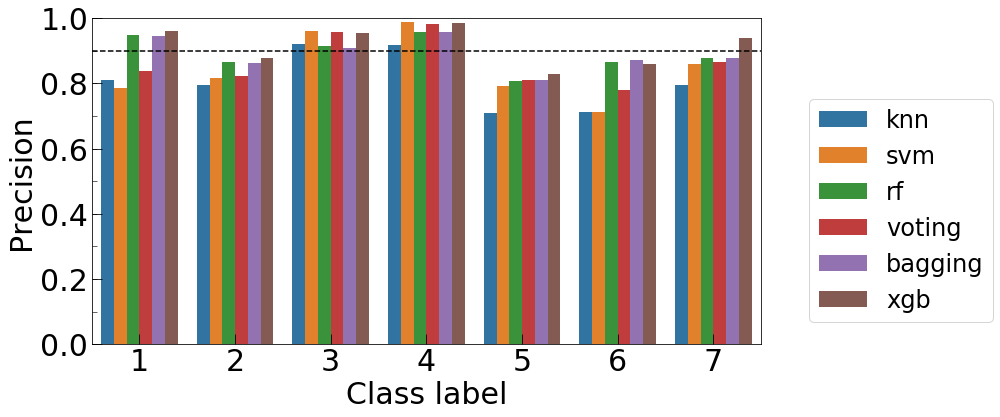

In [132]:
plt.figure(figsize=(12,6))
sns.barplot(x="Label_p", y ='precision', hue="model", data=score_dfs) 

plt.ylim(0,1)
plt.xlabel('Class label', fontsize=30)
plt.ylabel('Precision',fontsize=30)

plt.legend(bbox_to_anchor=(1, 0.9), loc=2, borderaxespad=2., fontsize=24) 


plt.tick_params(which='major',direction='in',length=10,labelsize=30)
plt.tick_params(which='minor',direction='in',length=5,labelsize=30)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) 
#plt.axhline(0.8,linestyle=':',c='k')
plt.axhline(0.9,linestyle='--',c='k')

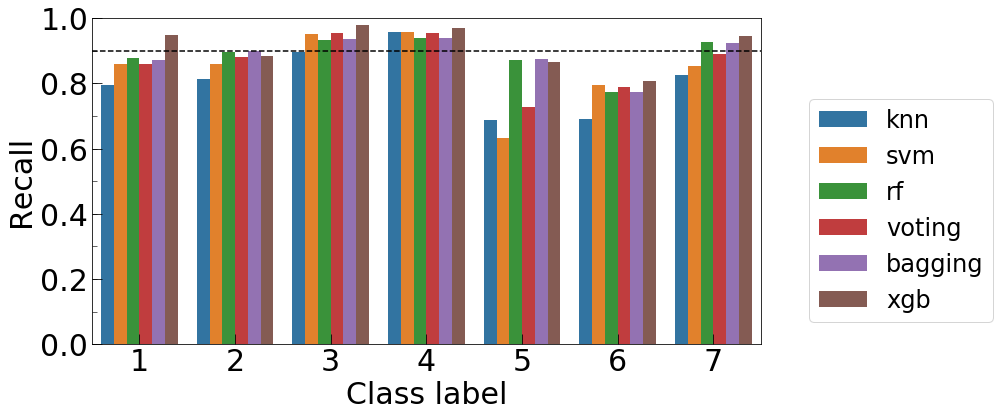

In [131]:
plt.figure(figsize=(12,6))
sns.barplot(x="Label_p", y ='recall', hue="model", data=score_dfs) 

plt.ylim(0,1)
plt.xlabel('Class label', fontsize=30)
plt.ylabel('Recall',fontsize=30)

plt.legend(bbox_to_anchor=(1, 0.9), loc=2, borderaxespad=2., fontsize=24) 


plt.tick_params(which='major',direction='in',length=10,labelsize=30)
plt.tick_params(which='minor',direction='in',length=5,labelsize=30)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) 
#plt.axhline(0.8,linestyle='--',c='k')
plt.axhline(0.9,linestyle='--',c='k')

In [ ]:
print("Voting versus Bagging: ")
stats, p_value = statistic_compare_two_models(voting_f1score_w,bagging_f1score_w,len(X_test),len(X_test),0.05,2)
print("stats={}, p value={}".format(stats,p_value))

# Convolutional Neural Network

## prepare data

In [4]:
# set hyperparameters for the window
num_feature = 3
window_size = 260   # 5 seconds
step_size   = 260   # 5 seconds
segments    = []
label       = []

In [175]:
labels, segments4all_array = preprocess_data(dfs, window_size, step_size, num_feature)

Processing the data of class: 1

Processing the data of class: 2

Processing the data of class: 3

Processing the data of class: 4

Processing the data of class: 5

Processing the data of class: 6

Processing the data of class: 7



In [176]:
print ("number of segments/samples: " + str(len(labels))) 
print ("segements shape: " + str(segments4all_array.shape)) 
print ("labels for segments:" + str(list(set(labels)))) 

number of segments/samples: 7393
segements shape: (7393, 3, 260)
labels for segments:[1, 2, 3, 4, 5, 6, 7]


In [177]:
labels_OneHot = pd.get_dummies(labels)
print ("labels shape: " + str(labels_OneHot.shape))

labels shape: (7393, 7)


In [178]:
scaler_pipeline = Pipeline([
                    ('robust_scaler',RobustScaler())  
                    ])

segments_scaled=[]
for m in range(0, segments4all_array.shape[0]):
    segments_scaled.append(scaler_pipeline.fit_transform(segments4all_array[m]))
    
segments_array_scaled = np.array(segments_scaled) 
print ("segements (scaled) shape: " + str(segments_array_scaled.shape))

segements (scaled) shape: (7393, 3, 260)


In [179]:
use_scaled_data = True # use scaled input data turns out to be essential

if use_scaled_data: 
    random_state = int(segments_array_scaled.shape[0]/70)
    X_train, X_test, y_train, y_test = train_test_split(segments_array_scaled,
                                                        labels_OneHot, 
                                                        test_size=0.2, 
                                                        random_state=random_state)
else:
    random_state = int(segments4all_array.shape[0]/70)
    X_train, X_test, y_train, y_test = train_test_split(segments4all_array,
                                                        labels_OneHot, 
                                                        test_size=0.2, 
                                                        random_state=random_state)

In [180]:
# make the dimension right for the CNN

X_train = np.expand_dims(X_train, axis=3)
X_test  = np.expand_dims(X_test, axis=3)  

print ("number of training segments = " + str(X_train.shape[0]))
print ("number of test segments = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training segments = 5914
number of test segments = 1479
X_train shape: (5914, 3, 260, 1)
Y_train shape: (5914, 7)
X_test shape: (1479, 3, 260, 1)
Y_test shape: (1479, 7)


## Save and reload data

In [6]:
 import hickle as hkl

In [192]:
train_data = (X_train,y_train)
test_data = (X_test,y_test)

In [194]:
X_train.shape

(5914, 3, 260, 1)

In [195]:
np.save('xtrain.npy', X_train)
np.save('ytrain.npy', y_train)
np.save('xtest.npy', X_test)
np.save('ytest.npy', y_test)

In [200]:
X_train_r = np.load('xtrain.npy')
X_train_r.shape

(5914, 3, 260, 1)

In [202]:
#

# data = {'xtrain': X_train, 'xtest': X_test,'ytrain': y_train,'ytest':y_test}
# hkl.dump(data,'data4cnn.hkl')

In [7]:
data = hkl.load('data4cnn.hkl') 

In [8]:
X_train = data['xtrain']
X_test  = data['xtest']
y_train = data['ytrain']
y_test  = data['ytest'] 

In [9]:
print ("number of training segments = " + str(X_train.shape[0]))
print ("number of test segments = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training segments = 5914
number of test segments = 1479
X_train shape: (5914, 3, 260, 1)
Y_train shape: (5914, 7)
X_test shape: (1479, 3, 260, 1)
Y_test shape: (1479, 7)


## Building the CNN model


Here, we adopt convolution neural network (CNN) to train the data.

- The pros of using the CNN here is this model has achived a great success in the computer vision. In this project, we divide the whole time-series data into lots of segments. Each segement has dimension (3, window_size), which can be regarded as an image. Therefore, it is natural to think of this model.

- The cons of this model is that this model belongs to ***black box*** models, which is not easy to interpret. 

- Both accuracy and f1 measure are adopted as metrics

In [ ]:
from keras.models import Sequential

In [13]:

# def model_simple(num_feature,window_size):
    
#     #create model
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(64, (2,2), activation='relu', input_shape=(num_feature,window_size,1))) # 64 nodes, 3x3 filter matrix
    
#     model.add(BatchNormalization())
    
#     model.add(Conv2D(36, (2,2), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(7, activation='softmax'))
#     return model

In [14]:
cnn_model_simple = model_simple(num_feature,window_size)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
def model_CX(num_feature,window_size):
    """
        
        """
    
    model = Sequential()
    model.add(Conv2D(18, (2, 12), padding='same', input_shape=(num_feature,window_size,1)))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(36, (1, 12), strides=2, padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(24, (1, 12), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))
    
    return model

In [17]:
cnn_model_CX = model_CX(num_feature, window_size)

In [23]:

# both accuracy and f1 measure are adopted as metrics
cnn_model_CX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1])
#train the model
cnn_model_CX.fit(X_train, y_train, batch_size=500, validation_data=(X_test, y_test), epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 5914 samples, validate on 1479 samples
Epoch 1/10
5914/5914 [==============================] - 3s 446us/step - loss: 1.6999 - acc: 0.3049 - f1: 0.0000e+00 - val_loss: 1.5929 - val_acc: 0.3158 - val_f1: 0.0013
Epoch 2/10
5914/5914 [==============================] - 2s 401us/step - loss: 1.5367 - acc: 0.3810 - f1: 0.0000e+00 - val_loss: 1.5093 - val_acc: 0.3820 - val_f1: 0.0134
Epoch 3/10
5914/5914 [==============================] - 2s 411us/step - loss: 1.4456 - acc: 0.4256 - f1: 0.1121 - val_loss: 1.3926 - val_acc: 0.4266 - val_f1: 0.1652
Epoch 4/10
5914/5914 [==============================] - 2s 381us/step - loss: 1.3486 - acc: 0.4790 - f1: 0.2358 - val_loss: 1.3111 - val_acc: 0.5030 - val_f1: 0.3469
Epoch 5/10
5914/5914 [==============================] - 2s 392us/step - loss: 1.2932 - acc: 0.5203 - f1: 0.3099 - val_loss: 1.2874 - val_acc: 0.5186 - val_f1: 0.3235
Epoch 6/10
5914/5914 [==============================] - 2s 403us/s

In [24]:
preds = cnn_model_CX.evaluate(X_test, y_test)

print ("Loss = " + str(preds[0]))  
print ("Test Accuracy = " + str(preds[1]))
print ("F1 score (macro) = " + str(preds[2]))

y_pred = cnn_model_CX.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(np.array(y_test).reshape(y_test.shape[0],7), axis=1) 
cnn_cm = confusion_matrix(y_test_classes,y_pred_classes)
print(cnn_cm)

1479/1479 [==============================] - 0s 160us/step
Loss = 1.2012392481571117
Test Accuracy = 0.5476673428193389
F1 score (macro) = 0.41085783298995704
[[194   0   2   8   0   0 263]
 [ 15   0   1   8   0   0  19]
 [ 16   0   1  45   0   0 105]
 [  3   0   2 227   0   0  35]
 [  4   0   1  22   0   0  19]
 [  2   0   0   7   0   0  25]
 [ 40   0   2  25   0   0 388]]


In [27]:
y_pred4train = cnn_model_CX.predict(X_train)

y_pred4train_classes = np.argmax(y_pred4train, axis=1) 

y_train_classes = np.argmax(np.array(y_train).reshape(y_train.shape[0],7), axis=1) 



In [28]:
y_train_classes.shape, y_pred4train_classes.shape

((5914,), (5914,))

In [29]:
cnn_cm4train = confusion_matrix(y_train_classes,y_pred4train_classes)

Text(0.5,1,' CNN for Train')

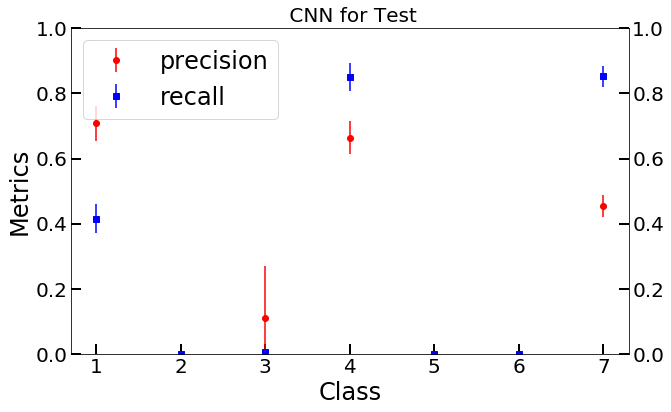

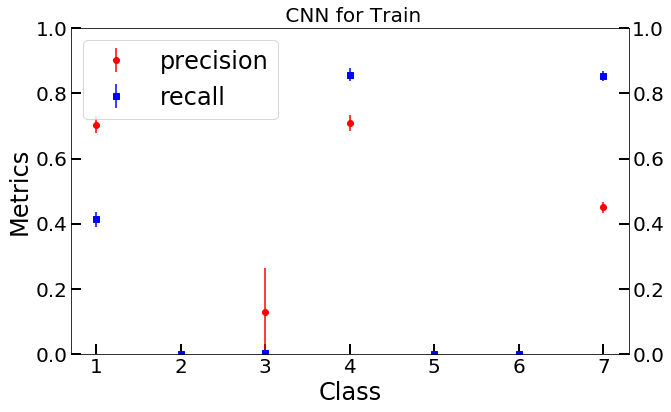

In [31]:
plot_score4each(cnn_cm)
plt.title(" CNN for Test", fontsize=20)
plot_score4each(cnn_cm4train)
plt.title(" CNN for Train", fontsize=20)

# Summary and outlook


In this notebook, I have presented a comprehensive study on the Human Activity Recognition based on the [wearable sensor data](https://drive.google.com/file/d/17qNfTHO3Uqsd7XWlDzjTjvuyEgJqEM6Y/view?usp=drive_web) using both conventional machine learning algorithms and the convolutional neural networks (CNN).


**The main findings**

- The importance of using balanced data in the training and test. The use of imbalanced training and test data
in the CNN simply cannot recognize the classes with small sample sizes. In contrast, the use of balanced data in the conventional machine learning models give roughly similar scores for all the classes.

- The best model performace among the models we used in this notebook is given by the xgboost algorithm which gives more than 90% score for the precision and recall in the test.


** Overfitting problems**

- The overfitting problem in the conventional machine learning models is not obvious, especially after using cross validation and ensemble method.  

- In the CNN model, we found that with the increase of epoch, the accuracy is smoothly increasing, while that of the validation data is almost constant (around 0.5). The accuracy of the test data is similar to that of the validation dataset. It implies that there is  **overfitting** problem in the CNN model.

- In the CNN model, the number of total parameters is more than one order of magnitude larger than the sample size (number of segments). The obvervation of overfitting is within expectation. To reduce the overfitting, one may need more data, including longer data and more features. 
 
** Outlook **

- It is interesting to do more detailed fine tunings on the parameters of these models with broden ranges. Besides, more complex deep-learning models, such as recurrent neural networl (RNN) and Long-Short-Term Memory (LSTM), can also be applied for this purpose. 

- The influence of window size on the prediction has been done in Random Forest Classfier model and the CNN model. It is shown that the precision/recall in the Random Forest Classfier model  is globally decreasing with the window size which can be understood in terms of sample size. As the increase of window size, the number of generated samples is decreasing. However, the window size effect is marginal in the CNN model.

- There might be some room to improve further the performace of the models used in this notebook. However, a significant improvement is not expected for this dataset.  
  
- From the data point of view, there are at least two ways to improve the precision of recognition. One way is collecting some information other than the accelaration along x,y,z direction, such as angles. Another way is collecting the data in longer time. These two ways can extend the data both in width and in length. In this way, the sample size will be significantly increased, and in this case, the deep learning models will do much better.

# Acknowledgement

I would like to thank Alexander Tolpygo, [SFL Scientific](https://sflscientific.com) for providing all the data for the project.